## Profeta Comex, um projeto de previsão de logística multi produto

Por meio deste projeto irei mostrar duas abordagens de previsões, uma em cima de dados mais abundantes porém em uma janela menor de tempo\
e outra por outra abordagem mais oculta que será necessário preencher vários dados, entretanto dá para conferir em sites chineses

Antes de rodar o projeto, instale os requerimentos pelo PyPI

In [798]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Obs: O Torch e algumas ferramentas são a versão para ROCm (AMD Radeon), caso use NVIDIA ou CPU, será necessário instalar as versões apropriadas

In [402]:
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore") 
import re
from datetime import date
import pandas as pd

In [2]:
torch.cuda.is_available()

True

In [3]:
Importacao = pd.read_csv("IMP_COMPLETA.csv", sep=';', encoding='latin1')

In [4]:
Exportacao = pd.read_csv("EXP_COMPLETA.csv", sep=';', encoding='latin1')

In [5]:
data_paises = pd.read_csv("PAIS.csv", sep=';', encoding='latin1')

In [6]:
dataSI = pd.read_csv("NCM_UNIDADE.csv", sep=';', encoding='latin1')

In [7]:
dataVia = pd.read_csv("VIA.csv", sep=';', encoding='latin1')

In [8]:
dataURF = pd.read_csv("URF.csv", sep=';', encoding='latin1')

In [9]:
NCM = pd.read_csv("NCM.csv", sep=';', encoding='latin1')
NCM = NCM.drop(columns={"NO_NCM_ESP", "NO_NCM_ING", "CO_EXP_SUBSET", "CO_ISIC_CLASSE", "CO_SIIT", "CO_CGCE_N3", "CO_CUCI_ITEM",
                  "CO_FAT_AGREG", "CO_PPI", "CO_PPE", "CO_UNID", "CO_SH6"})

In [10]:
NCM

,CO_NCM,NO_NCM_POR
0,59112090,"Gazes e telas para peneirar, mesmo confecciona..."
1,59113100,"Tecidos e feltros, sem fim ou com dispositivos..."
2,59113200,"Tecidos e feltros, sem fim ou com dispositivos..."
3,59114000,"Tecidos filtrantes e tecidos espessos, compree..."
4,51121100,Tecidos de lã penteada ou de pelos finos pente...
...,...,...
13655,48056000,"Outros papéis/cartões, não revestidos, em rolo..."
13656,48101489,"Outros papéis para escrita, etc, fibra <= 10%,..."
13657,48101490,"Outros papéis para escrita, etc, fibra <= 10%,..."
13658,39211200,"Outras chapas, folhas, películas, tiras e lâmi..."


In [11]:
def Produto(Consulta, DS):
    
    if(type(Consulta) == int):
        print('Foi inserido NCM')
        DFConsulta = DS[DS['CO_NCM'] == Consulta]
        DFConsulta = DS.merge(NCM[NCM['CO_NCM'] == Consulta], how='inner', on='CO_NCM')
    else:    
        print('Foi inserido nome do produto')
        DFConsulta = DS.merge(NCM[NCM['NO_NCM_POR'].str.contains(Consulta, case = False)], how='inner', on='CO_NCM')

    DFConsulta.fillna(0, inplace=True) 
    DFConsulta = DFConsulta.astype({'CO_MES': int, 'CO_NCM':int, 'CO_UNID':int, 'CO_PAIS':int, 'CO_VIA':int, 'CO_URF':int, 'VL_FOB':int})
    DFConsulta = DFConsulta[(DFConsulta['KG_LIQUIDO'] > 0) & (DFConsulta['VL_FOB'] > 0)]
    DFConsulta = DFConsulta.sort_values(by=['CO_ANO', 'CO_MES', 'CO_NCM'])
    #juntar dados por mês, ano e NCM, somar peso e fob por mes e fazer media do preço_kg
    DFConsulta = DFConsulta.groupby(["CO_ANO", "CO_MES", "CO_NCM"], as_index=False).agg({ #as_index para não gerar multiindex (hierarquia de índices)
    "KG_LIQUIDO": "sum",
    "VL_FOB": "sum",
    "NO_NCM_POR": "first", 
    })

    DFConsulta["PRECO_KG"] = (DFConsulta["VL_FOB"]) / (DFConsulta["KG_LIQUIDO"])

    DFConsulta = DFConsulta.reindex(['CO_MES', 'CO_ANO', 'NO_NCM_POR', 'CO_NCM', 'KG_LIQUIDO', 'PRECO_KG', 'VL_FOB'], axis=1)

    return DFConsulta

Para analisarmos a previsão de algo, basta entrarmos com nome ou NCM e a base, se será de exportação ou importação \
Podemos também criar quantos modelos distintos quiser por meio da criação de variáveis\
Dica: Se digitar espaço entre aspas, o código irá retornar todos os produtos da base

Caso o dado não apareça após pesquisar pelo nome, melhor pesquisar pelo NCM, isso acontece em casos onde os dados começam mais tarde que os demais

In [12]:
dados = Produto(12019000, Exportacao)
linho = Produto('linho', Importacao)

Foi inserido NCM
Foi inserido nome do produto


In [13]:
dados

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB
0,1,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,593295072,0.451748,268019783
1,2,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,1538331088,0.456592,702390063
2,3,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4236918750,0.486842,2062711593
3,4,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4430830149,0.510402,2261503830
4,5,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,7274064241,0.527838,3839528828
...,...,...,...,...,...,...,...
142,11,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,5196051097,0.524794,2726857445
143,12,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,3828588811,0.519796,1990085159
144,1,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,2854860075,0.509768,1455317110
145,2,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,6608133605,0.442186,2922023528


In [14]:
linho

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB
0,1,1997,"Linho espadelado, mas não fiado",53012120,35920,2.070267,74364
1,1,1997,"Linho penteado, mas não fiado",53012910,43934,3.097168,136071
2,1,1997,Estopas e desperdícios de linho,53013000,8945,1.744997,15609
3,1,1997,"Fios de linho, simples",53061000,19530,9.170251,179095
4,1,1997,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,25815,4.060662,104826
...,...,...,...,...,...,...,...
3032,3,2024,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,10591,20.840431,220721
3033,3,2024,"Outros tecidos de linho, que contenham pelo me...",53091900,43843,19.815774,868783
3034,3,2024,"Tecidos de linho, que contenham menos de 85 %,...",53092100,42807,7.798374,333825
3035,3,2024,"Outros tecidos de linho, que contenham menos d...",53092900,121609,7.810376,949812


Serão excluidos os produtos que não possuem dados suficientes para análise, neste caso, o ano atual menos o primeiro ano da base\
 dividido por 2\
 Também serão excluidos os anos por NCM que contem menos que 6 meses de dados\
 As vezes é melhor perder alguns dados do que ter falsos positivos

In [15]:
def limpeza(DataF):
    DS = DataF.copy()
    for j in DS['CO_NCM'].unique():
        if(DS[DS['CO_NCM'] == j]['KG_LIQUIDO'].count() < (((date.today().year - DS['CO_ANO'].min()) * 12)/2)):
             DS = DS.drop(DS[DS['CO_NCM'] == j].index)

    #por questões de perder dados importantes que podem revelar alta de preço e baixa na demanda em certos anos, a ideia abaixo foi descartada
    #for j in DS['CO_NCM'].unique(): #para cada NCM
        #for i in range(DS['CO_ANO'].min(), date.today().year): #do primeiro ano da base até ano passado
            #if(DS[(DS['CO_NCM'] == j) & (DS['CO_ANO'] == i)]['PRECO_KG'].count() < 6):
                #DS = DS.drop(DS[(DS['CO_NCM'] == j) & (DS['CO_ANO'] == i)].index)
                
    return DS

In [16]:
dados = limpeza(dados)
linho = limpeza(linho)

In [17]:
dados

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB
0,1,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,593295072,0.451748,268019783
1,2,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,1538331088,0.456592,702390063
2,3,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4236918750,0.486842,2062711593
3,4,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4430830149,0.510402,2261503830
4,5,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,7274064241,0.527838,3839528828
...,...,...,...,...,...,...,...
142,11,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,5196051097,0.524794,2726857445
143,12,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,3828588811,0.519796,1990085159
144,1,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,2854860075,0.509768,1455317110
145,2,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,6608133605,0.442186,2922023528


In [18]:
linho

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB
1,1,1997,"Linho penteado, mas não fiado",53012910,43934,3.097168,136071
3,1,1997,"Fios de linho, simples",53061000,19530,9.170251,179095
4,1,1997,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,25815,4.060662,104826
5,1,1997,"Outros tecidos de linho, que contenham pelo me...",53091900,6614,18.587239,122936
6,2,1997,"Outras sementes de linho (linhaça), mesmo trit...",12040090,27000,0.380000,10260
...,...,...,...,...,...,...,...
3032,3,2024,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,10591,20.840431,220721
3033,3,2024,"Outros tecidos de linho, que contenham pelo me...",53091900,43843,19.815774,868783
3034,3,2024,"Tecidos de linho, que contenham menos de 85 %,...",53092100,42807,7.798374,333825
3035,3,2024,"Outros tecidos de linho, que contenham menos d...",53092900,121609,7.810376,949812


In [19]:
dados.set_index('CO_NCM')['NO_NCM_POR'].to_dict()

{12019000: 'Soja, mesmo triturada, exceto para semeadura'}

In [20]:
linho.set_index('CO_NCM')['NO_NCM_POR'].to_dict()

{53012910: 'Linho penteado, mas não fiado',
 53061000: 'Fios de linho, simples',
 53091100: 'Tecidos de linho, que contenham pelo menos 85 %, em peso, de linho, crus ou branqueados',
 53091900: 'Outros tecidos de linho, que contenham pelo menos 85 %, em peso, de linho',
 12040090: 'Outras sementes de linho (linhaça), mesmo trituradas',
 53092900: 'Outros tecidos de linho, que contenham menos de 85 %, em peso, de linho',
 53092100: 'Tecidos de linho, que contenham menos de 85 %, em peso, de linho, crus ou branqueados',
 53012990: 'Linho trabalhado de outra forma, mas não fiado',
 53062000: 'Fios de linho, retorcidos ou retorcidos múltiplos',
 63025910: 'Roupas de mesa de linho, exceto de malha'}

Este código transforma o dataset para uma melhor visualização final dos dados, mas será usado em uma versão futura

In [21]:
def Transforma(DS):
    DS = DS.rename(columns={'CO_UNID': 'NO_UNID'})
    DS = DS.rename(columns={'CO_PAIS': 'NO_PAIS'})
    DS = DS.rename(columns={'CO_VIA': 'NO_VIA'})
    DS = DS.rename(columns={'CO_URF': 'NO_URF'})
    DS['NO_UNID'] = DS['NO_UNID'].astype(str)
    DS['NO_PAIS'] = DS['NO_PAIS'].astype(str)
    DS['NO_VIA'] = DS['NO_VIA'].astype(str)
    DS['NO_URF'] = DS['NO_URF'].astype(str)
    
    for NO_UNID in DS["NO_UNID"]:
        if NO_UNID in dataSI["CO_UNID"].values:
            DS["NO_UNID"] = DS["NO_UNID"].replace(NO_UNID, dataSI[dataSI["CO_UNID"] == NO_UNID]["NO_UNID"].values[0])
            
    for NO_PAIS in DS["NO_PAIS"]:
        if NO_PAIS in data_paises["CO_PAIS"].values:
            DS["NO_PAIS"] = DS["NO_PAIS"].replace(NO_PAIS, data_paises[data_paises["CO_PAIS"] == NO_PAIS]["NO_PAIS"].values[0])
            
    for NO_VIA in DS["NO_VIA"]:
        if NO_VIA in dataVia["CO_VIA"].values:
            DS["NO_VIA"] = DS["NO_VIA"].replace(NO_VIA, dataVia[dataVia["CO_VIA"] == NO_VIA]["NO_VIA"].values[0])
            
    for NO_URF in DS["NO_URF"]:
        if NO_URF in dataURF["CO_URF"].values:
            DS["NO_URF"] = DS["NO_URF"].replace(NO_URF, dataURF[dataURF["CO_URF"] == NO_URF]["NO_URF"].values[0])

    return DS

Dado à complexidade vista anteriormente e esses dados serem bem massivos, vamos verificar as unidades por código

In [22]:
dataSI

,CO_UNID,NO_UNID,SG_UNID
0,10,QUILOGRAMA LIQUIDO,KGL
1,11,NUMERO (UNIDADE),UNID.
2,12,MILHEIRO,MIL
3,13,PARES,PARES
4,14,METRO,M
5,15,METRO QUADRADO,M2
6,16,METRO CUBICO,M3
7,17,LITRO,LITRO
8,18,MIL QUILOWATT HORA,MKW/H
9,19,QUILATE,QUILT


No caso de fios de linho e soja não precisamos se preocupar com a unidade, pois todos da pesquisa são em KG/L, mas pode servir para outros produtos

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

Serão gerados z-scores para estes dados, eles serão gerados considerando ano e tipo de produto \
Motivo: Inflação de cada ano e variação de preço por produto\
Anos cujo tinha menos que 6 dados por NCM foram removidos a fim de não ter falsos positivos (Z = 1)

In [24]:
from scipy import stats

def ZAno(DataF):
    DS = DataF.copy()
    
    DS['Z_PRECO'] = np.nan

    for j in DS['CO_NCM'].unique(): #para cada NCM
        for i in range(DS['CO_ANO'].min(), date.today().year + 1): #do primeiro ano da base até o atual
            DS.loc[((DS['CO_NCM'] == j) & (DS['CO_ANO'] == i)), 'Z_PRECO'] = np.abs(stats.zscore(DS[(DS['CO_NCM'] == j) & (DS['CO_ANO'] == i)]['PRECO_KG'], axis = 0))
            
    return DS

In [25]:
dados = ZAno(dados)
linho = ZAno(linho)

In [26]:
dados[(dados['CO_NCM'] == 12019000) & (dados['CO_ANO'] == 2019)]

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB,Z_PRECO
84,1,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,2033968046,0.377888,768611580,2.124407
85,2,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,5267176925,0.355889,1874531657,0.045012
86,3,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,8454121953,0.357180,3019645535,0.167045
87,4,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,9403697999,0.351351,3303997442,0.383976
88,5,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,10011339443,0.339907,3402923554,1.465708
89,6,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,8552638109,0.337188,2883844074,1.722745
90,7,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,7443332215,0.349089,2598387335,0.597753
91,8,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,5001409754,0.352320,1762094845,0.292404
92,9,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,4603504482,0.354855,1633578583,0.052709
93,10,2019,"Soja, mesmo triturada, exceto para semeadura",12019000,5076033742,0.359656,1825626269,0.401067


In [27]:
linho[(linho['CO_NCM'] == 53061000) & (linho['CO_ANO'] == 2019)]

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB,Z_PRECO
2439,1,2019,"Fios de linho, simples",53061000,11941,9.430617,112611,0.590020
2447,2,2019,"Fios de linho, simples",53061000,7920,10.325253,81776,0.362291
2456,3,2019,"Fios de linho, simples",53061000,5098,10.557081,53820,0.303278
2464,4,2019,"Fios de linho, simples",53061000,579,24.031088,13914,3.126536
2474,5,2019,"Fios de linho, simples",53061000,13080,11.774159,154006,0.006529
2484,6,2019,"Fios de linho, simples",53061000,15836,11.891008,188306,0.036273
2494,7,2019,"Fios de linho, simples",53061000,14068,7.744669,108952,1.019179
2504,8,2019,"Fios de linho, simples",53061000,7500,11.624267,87182,0.031626
2514,9,2019,"Fios de linho, simples",53061000,13320,11.815090,157377,0.016948
2524,10,2019,"Fios de linho, simples",53061000,13320,11.800976,157189,0.013356


Por algum motivo meu pyplot plota função densidade de probabilidade bugado, então o jeito é ver o vetor de saída

In [28]:
dados[(dados['CO_NCM'] == 12019000) & (dados['CO_ANO'] == 2019)][['PRECO_KG']].to_numpy().transpose().reshape(-1)

array([0.37788774, 0.35588925, 0.35718027, 0.35135087, 0.33990692,
       0.33718767, 0.34908926, 0.35231963, 0.35485543, 0.35965605,
       0.36542984, 0.36420371])

In [29]:
import scipy.stats as stats
x = dados[(dados['CO_NCM'] == 12019000) & (dados['CO_ANO'] == 2019)][['PRECO_KG']].to_numpy().transpose().reshape(-1)
z_scores = abs(stats.zscore(x))
z_scores

array([2.12440676, 0.04501247, 0.16704491, 0.38397586, 1.46570848,
       1.72274451, 0.59775295, 0.29240384, 0.05270856, 0.40106736,
       0.94683117, 0.83093155])

In [30]:
linho[(linho['CO_NCM'] == 53061000) & (linho['CO_ANO'] == 2019)][['PRECO_KG']].to_numpy().transpose().reshape(-1)

array([ 9.4306172 , 10.32525253, 10.55708121, 24.03108808, 11.77415902,
       11.89100783,  7.74466875, 11.62426667, 11.81509009, 11.80097598,
        8.71215441, 11.27574529])

In [31]:
x = linho[(linho['CO_NCM'] == 53061000) & (linho['CO_ANO'] == 2019)][['PRECO_KG']].to_numpy().transpose().reshape(-1)
z_scores = abs(stats.zscore(x))
z_scores

array([0.59002039, 0.36229056, 0.30327846, 3.12653609, 0.00652924,
       0.03627316, 1.01917933, 0.03162592, 0.01694827, 0.01335551,
       0.77290542, 0.1203422 ])

Ok, a função de estimar z-score está funcionando, agora vamos verificar os outliers

In [33]:
dados

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB,Z_PRECO
0,1,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,593295072,0.451748,268019783,1.476419
1,2,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,1538331088,0.456592,702390063,1.405857
2,3,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4236918750,0.486842,2062711593,0.965243
3,4,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4430830149,0.510402,2261503830,0.622083
4,5,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,7274064241,0.527838,3839528828,0.368111
...,...,...,...,...,...,...,...,...
142,11,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,5196051097,0.524794,2726857445,0.128585
143,12,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,3828588811,0.519796,1990085159,0.299335
144,1,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,2854860075,0.509768,1455317110,1.393687
145,2,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,6608133605,0.442186,2922023528,0.488934


In [34]:
linho

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB,Z_PRECO
1,1,1997,"Linho penteado, mas não fiado",53012910,43934,3.097168,136071,0.390849
3,1,1997,"Fios de linho, simples",53061000,19530,9.170251,179095,1.195651
4,1,1997,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,25815,4.060662,104826,0.690330
5,1,1997,"Outros tecidos de linho, que contenham pelo me...",53091900,6614,18.587239,122936,0.475424
6,2,1997,"Outras sementes de linho (linhaça), mesmo trit...",12040090,27000,0.380000,10260,0.327380
...,...,...,...,...,...,...,...,...
3032,3,2024,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,10591,20.840431,220721,0.144859
3033,3,2024,"Outros tecidos de linho, que contenham pelo me...",53091900,43843,19.815774,868783,1.407436
3034,3,2024,"Tecidos de linho, que contenham menos de 85 %,...",53092100,42807,7.798374,333825,0.571012
3035,3,2024,"Outros tecidos de linho, que contenham menos d...",53092900,121609,7.810376,949812,0.000533


Conforme a curva de sino (Bell Curve) e a visualização de dados, vamos remover os quais tem Z maior que 2.6

In [35]:
dados = dados[dados["Z_PRECO"] < 2.6] 
linho = linho[linho["Z_PRECO"] < 2.6]

In [36]:
dados

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB,Z_PRECO
0,1,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,593295072,0.451748,268019783,1.476419
1,2,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,1538331088,0.456592,702390063,1.405857
2,3,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4236918750,0.486842,2062711593,0.965243
3,4,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4430830149,0.510402,2261503830,0.622083
4,5,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,7274064241,0.527838,3839528828,0.368111
...,...,...,...,...,...,...,...,...
142,11,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,5196051097,0.524794,2726857445,0.128585
143,12,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,3828588811,0.519796,1990085159,0.299335
144,1,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,2854860075,0.509768,1455317110,1.393687
145,2,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,6608133605,0.442186,2922023528,0.488934


In [37]:
linho

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB,Z_PRECO
1,1,1997,"Linho penteado, mas não fiado",53012910,43934,3.097168,136071,0.390849
3,1,1997,"Fios de linho, simples",53061000,19530,9.170251,179095,1.195651
4,1,1997,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,25815,4.060662,104826,0.690330
5,1,1997,"Outros tecidos de linho, que contenham pelo me...",53091900,6614,18.587239,122936,0.475424
6,2,1997,"Outras sementes de linho (linhaça), mesmo trit...",12040090,27000,0.380000,10260,0.327380
...,...,...,...,...,...,...,...,...
3032,3,2024,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,10591,20.840431,220721,0.144859
3033,3,2024,"Outros tecidos de linho, que contenham pelo me...",53091900,43843,19.815774,868783,1.407436
3034,3,2024,"Tecidos de linho, que contenham menos de 85 %,...",53092100,42807,7.798374,333825,0.571012
3035,3,2024,"Outros tecidos de linho, que contenham menos d...",53092900,121609,7.810376,949812,0.000533


Antes de preenchermos e prevermos, vamos criar uma tag para identificar dados reais e gerados

In [38]:
def Tag(DS):
    DS['Preenchido/Previsto'] = 'Não'
    return DS

In [39]:
dados = Tag(dados)
linho = Tag(linho)

In [40]:
dados

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB,Z_PRECO,Preenchido/Previsto
0,1,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,593295072,0.451748,268019783,1.476419,Não
1,2,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,1538331088,0.456592,702390063,1.405857,Não
2,3,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4236918750,0.486842,2062711593,0.965243,Não
3,4,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,4430830149,0.510402,2261503830,0.622083,Não
4,5,2012,"Soja, mesmo triturada, exceto para semeadura",12019000,7274064241,0.527838,3839528828,0.368111,Não
...,...,...,...,...,...,...,...,...,...
142,11,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,5196051097,0.524794,2726857445,0.128585,Não
143,12,2023,"Soja, mesmo triturada, exceto para semeadura",12019000,3828588811,0.519796,1990085159,0.299335,Não
144,1,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,2854860075,0.509768,1455317110,1.393687,Não
145,2,2024,"Soja, mesmo triturada, exceto para semeadura",12019000,6608133605,0.442186,2922023528,0.488934,Não


In [41]:
linho

,CO_MES,CO_ANO,NO_NCM_POR,CO_NCM,KG_LIQUIDO,PRECO_KG,VL_FOB,Z_PRECO,Preenchido/Previsto
1,1,1997,"Linho penteado, mas não fiado",53012910,43934,3.097168,136071,0.390849,Não
3,1,1997,"Fios de linho, simples",53061000,19530,9.170251,179095,1.195651,Não
4,1,1997,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,25815,4.060662,104826,0.690330,Não
5,1,1997,"Outros tecidos de linho, que contenham pelo me...",53091900,6614,18.587239,122936,0.475424,Não
6,2,1997,"Outras sementes de linho (linhaça), mesmo trit...",12040090,27000,0.380000,10260,0.327380,Não
...,...,...,...,...,...,...,...,...,...
3032,3,2024,"Tecidos de linho, que contenham pelo menos 85 ...",53091100,10591,20.840431,220721,0.144859,Não
3033,3,2024,"Outros tecidos de linho, que contenham pelo me...",53091900,43843,19.815774,868783,1.407436,Não
3034,3,2024,"Tecidos de linho, que contenham menos de 85 %,...",53092100,42807,7.798374,333825,0.571012,Não
3035,3,2024,"Outros tecidos de linho, que contenham menos d...",53092900,121609,7.810376,949812,0.000533,Não


Gerando meses faltantes 

In [42]:
from itertools import product

def Fill(DataF):

    DS = DataF.copy()
    years = pd.DataFrame({'CO_ANO': range(DS['CO_ANO'].min(), date.today().year)})
    months = pd.DataFrame({'CO_MES': range(1, 13)})
    ncms = pd.DataFrame({'CO_NCM': DS['CO_NCM'].unique()})

    all_combinations = pd.DataFrame(product(years['CO_ANO'], months['CO_MES'], ncms['CO_NCM']), columns=['CO_ANO', 'CO_MES', 'CO_NCM'])

    years = pd.DataFrame({'CO_ANO': [date.today().year]})
    months = pd.DataFrame({'CO_MES': range(1, date.today().month)})
    ncms = pd.DataFrame({'CO_NCM': DS['CO_NCM'].unique()})

    all_combinations = pd.concat([all_combinations, pd.DataFrame(product(years['CO_ANO'], months['CO_MES'], ncms['CO_NCM']), columns=['CO_ANO', 'CO_MES', 'CO_NCM'])], ignore_index=True)
    
    DS = DS.drop(['Z_PRECO'], axis=1)
    
    DS = pd.merge(all_combinations, DS, on=['CO_ANO', 'CO_MES', 'CO_NCM'], how='left')

    ncm_mapping = NCM.set_index('CO_NCM')['NO_NCM_POR'].to_dict()
    DS['NO_NCM_POR'] = DS['NO_NCM_POR'].fillna(DS['CO_NCM'].map(ncm_mapping))
    DS['KG_LIQUIDO'] = DS['KG_LIQUIDO'].fillna(0)
    DS['VL_FOB'] = DS['VL_FOB'].fillna(0)
    DS['Preenchido/Previsto'] = DS['Preenchido/Previsto'].fillna('Sim')

    return DS

In [43]:
dados = Fill(dados)
linho = Fill(linho)

In [44]:
dados

,CO_ANO,CO_MES,CO_NCM,NO_NCM_POR,KG_LIQUIDO,PRECO_KG,VL_FOB,Preenchido/Previsto
0,2012,1,12019000,"Soja, mesmo triturada, exceto para semeadura",5.932951e+08,0.451748,2.680198e+08,Não
1,2012,2,12019000,"Soja, mesmo triturada, exceto para semeadura",1.538331e+09,0.456592,7.023901e+08,Não
2,2012,3,12019000,"Soja, mesmo triturada, exceto para semeadura",4.236919e+09,0.486842,2.062712e+09,Não
3,2012,4,12019000,"Soja, mesmo triturada, exceto para semeadura",4.430830e+09,0.510402,2.261504e+09,Não
4,2012,5,12019000,"Soja, mesmo triturada, exceto para semeadura",7.274064e+09,0.527838,3.839529e+09,Não
...,...,...,...,...,...,...,...,...
143,2023,12,12019000,"Soja, mesmo triturada, exceto para semeadura",3.828589e+09,0.519796,1.990085e+09,Não
144,2024,1,12019000,"Soja, mesmo triturada, exceto para semeadura",2.854860e+09,0.509768,1.455317e+09,Não
145,2024,2,12019000,"Soja, mesmo triturada, exceto para semeadura",6.608134e+09,0.442186,2.922024e+09,Não
146,2024,3,12019000,"Soja, mesmo triturada, exceto para semeadura",1.263048e+10,0.427259,5.396486e+09,Não


In [45]:
linho

,CO_ANO,CO_MES,CO_NCM,NO_NCM_POR,KG_LIQUIDO,PRECO_KG,VL_FOB,Preenchido/Previsto
0,1997,1,53012910,"Linho penteado, mas não fiado",43934.0,3.097168,136071.0,Não
1,1997,1,53061000,"Fios de linho, simples",19530.0,9.170251,179095.0,Não
2,1997,1,53091100,"Tecidos de linho, que contenham pelo menos 85 ...",25815.0,4.060662,104826.0,Não
3,1997,1,53091900,"Outros tecidos de linho, que contenham pelo me...",6614.0,18.587239,122936.0,Não
4,1997,1,12040090,"Outras sementes de linho (linhaça), mesmo trit...",0.0,NaN,0.0,Sim
...,...,...,...,...,...,...,...,...
3275,2024,4,53092900,"Outros tecidos de linho, que contenham menos d...",0.0,NaN,0.0,Sim
3276,2024,4,53092100,"Tecidos de linho, que contenham menos de 85 %,...",0.0,NaN,0.0,Sim
3277,2024,4,53012990,"Linho trabalhado de outra forma, mas não fiado",0.0,NaN,0.0,Sim
3278,2024,4,53062000,"Fios de linho, retorcidos ou retorcidos múltiplos",0.0,NaN,0.0,Sim


Os dados serão preenchidos com um algortitmo chamado SAITS, método de imputação baseado em Self-Attention \
Wenjie Du, David Cote, and Yan Liu. SAITS: Self-Attention-based Imputation for Time Series. Expert Systems with Applications, 219:119619, 2023. https://doi.org/10.1016/j.eswa.2023.119619

In [46]:
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_mae

def FillSAITS(DataF): 
    DS = DataF.copy()
    num_samples = len(DS['CO_NCM'].unique()) #Quantidade de NCMs
    n_steps = (((date.today().year) - DS['CO_ANO'].min()) * 12) + ((date.today().month) - 1) #Quantos meses totais
    DS = DS.sort_values(by=['CO_NCM', 'CO_ANO', 'CO_MES']) #precisamos ordenar por NCM
    DS = DS.drop(['CO_MES', 'CO_ANO', 'CO_NCM', 'NO_NCM_POR', 'Preenchido/Previsto'], axis = 1) #Agora preencher apenas dados numéricos
    n_features = DS.shape[1] #quantas colunas?
    stdScaler = StandardScaler() #parece bizarro, mas isso só funciona se salvar em variável
    DS = stdScaler.fit_transform(DS.to_numpy()) #antes do reshape
    DS = DS.reshape(num_samples, n_steps, -1)
    DS_ori = DS  #Salvar original para validação
    DS = mcar(DS, 0.1)  # aleatoriamente pega 10% dos valores observados como verdade absoluta
    dataset = {"X": DS}  # X para entrada do modelo, a saida não retorna X
    print(DS.shape) 
    saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256, d_ffn=128, n_heads=4, d_k=64, d_v=64, dropout=0.12, epochs=1300) #
    saits.fit(dataset)
    imputation = saits.impute(dataset)  # preenche os valores perdidos originais e artificiais para fins de análise
    indicating_mask = np.isnan(DS) ^ np.isnan(DS_ori)  # mascara para calculo de erro 
    mae = calc_mae(imputation, np.nan_to_num(DS_ori), indicating_mask)  # Calcula MAE em cima dos valores reais (valores perdidos artificialmente)
    original = {"X": DS_ori}  # X para entrada do modelo
    preench = saits.impute(original)  #preenche os valores perdidos originais
    preench = preench.reshape((num_samples * n_steps), n_features) #volta ao formato original
    return stdScaler.inverse_transform(preench)


2024-05-20 00:39:08.549064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 00:39:09.273488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Este método de preenchimento ainda está em estágio beta, 
## existem alguns bugs como poder aparecer NAN na previsão e ele parar com erro alto 
## Por conta disso, antes de preencher os dados de fato, é necessário analisar

In [47]:
gerar = FillSAITS(dados)

2024-05-20 00:39:13 [INFO]: No given device, using default device: cuda
2024-05-20 00:39:13 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-05-20 00:39:13 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,321,946


(1, 148, 3)


2024-05-20 00:39:14 [INFO]: Epoch 001 - training loss: 1.8189
2024-05-20 00:39:14 [INFO]: Epoch 002 - training loss: 2.1630
2024-05-20 00:39:14 [INFO]: Epoch 003 - training loss: 1.7371
2024-05-20 00:39:14 [INFO]: Epoch 004 - training loss: 1.5968
2024-05-20 00:39:14 [INFO]: Epoch 005 - training loss: 1.5670
2024-05-20 00:39:14 [INFO]: Epoch 006 - training loss: 1.4310
2024-05-20 00:39:14 [INFO]: Epoch 007 - training loss: 1.3259
2024-05-20 00:39:14 [INFO]: Epoch 008 - training loss: 1.1522
2024-05-20 00:39:14 [INFO]: Epoch 009 - training loss: 1.1325
2024-05-20 00:39:14 [INFO]: Epoch 010 - training loss: 1.0950
2024-05-20 00:39:14 [INFO]: Epoch 011 - training loss: 1.1231
2024-05-20 00:39:14 [INFO]: Epoch 012 - training loss: 1.0986
2024-05-20 00:39:15 [INFO]: Epoch 013 - training loss: 1.0513
2024-05-20 00:39:15 [INFO]: Epoch 014 - training loss: 0.9791
2024-05-20 00:39:15 [INFO]: Epoch 015 - training loss: 0.9976
2024-05-20 00:39:15 [INFO]: Epoch 016 - training loss: 1.0078
2024-05-

In [48]:
gerarLinho = FillSAITS(linho)

2024-05-20 00:39:36 [INFO]: No given device, using default device: cuda
2024-05-20 00:39:36 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-05-20 00:39:36 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,322,486
2024-05-20 00:39:36 [INFO]: Epoch 001 - training loss: 1.2257
2024-05-20 00:39:36 [INFO]: Epoch 002 - training loss: 1.7692
2024-05-20 00:39:36 [INFO]: Epoch 003 - training loss: 1.4705
2024-05-20 00:39:36 [INFO]: Epoch 004 - training loss: 0.9832
2024-05-20 00:39:36 [INFO]: Epoch 005 - training loss: 1.1696
2024-05-20 00:39:36 [INFO]: Epoch 006 - training loss: 1.1811


(10, 328, 3)


2024-05-20 00:39:36 [INFO]: Epoch 007 - training loss: 1.0472
2024-05-20 00:39:36 [INFO]: Epoch 008 - training loss: 0.9639
2024-05-20 00:39:36 [INFO]: Epoch 009 - training loss: 0.9039
2024-05-20 00:39:36 [INFO]: Epoch 010 - training loss: 0.9025
2024-05-20 00:39:36 [INFO]: Epoch 011 - training loss: 0.8840
2024-05-20 00:39:36 [INFO]: Epoch 012 - training loss: 0.8851
2024-05-20 00:39:36 [INFO]: Epoch 013 - training loss: 0.8674
2024-05-20 00:39:36 [INFO]: Epoch 014 - training loss: 0.8050
2024-05-20 00:39:36 [INFO]: Epoch 015 - training loss: 0.8125
2024-05-20 00:39:36 [INFO]: Epoch 016 - training loss: 0.8186
2024-05-20 00:39:36 [INFO]: Epoch 017 - training loss: 0.8075
2024-05-20 00:39:36 [INFO]: Epoch 018 - training loss: 0.7595
2024-05-20 00:39:36 [INFO]: Epoch 019 - training loss: 0.7659
2024-05-20 00:39:36 [INFO]: Epoch 020 - training loss: 0.7487
2024-05-20 00:39:36 [INFO]: Epoch 021 - training loss: 0.7339
2024-05-20 00:39:36 [INFO]: Epoch 022 - training loss: 0.7293
2024-05-

In [49]:
teste_fill = dados.sort_values(by=['CO_NCM', 'CO_ANO', 'CO_MES']) #precisamos ordenar por NCM
teste_fill.insert(loc = 6, column='PRECO_GERADO', value=gerar[:, 1])
linho_fill = linho.sort_values(by=['CO_NCM', 'CO_ANO', 'CO_MES']) 
linho_fill.insert(loc = 6, column='PRECO_GERADO', value=gerarLinho[:, 1])

In [50]:
teste_fill[(teste_fill['CO_NCM'] == 12019000)]

,CO_ANO,CO_MES,CO_NCM,NO_NCM_POR,KG_LIQUIDO,PRECO_KG,PRECO_GERADO,VL_FOB,Preenchido/Previsto
0,2012,1,12019000,"Soja, mesmo triturada, exceto para semeadura",5.932951e+08,0.451748,0.451748,2.680198e+08,Não
1,2012,2,12019000,"Soja, mesmo triturada, exceto para semeadura",1.538331e+09,0.456592,0.456592,7.023901e+08,Não
2,2012,3,12019000,"Soja, mesmo triturada, exceto para semeadura",4.236919e+09,0.486842,0.486842,2.062712e+09,Não
3,2012,4,12019000,"Soja, mesmo triturada, exceto para semeadura",4.430830e+09,0.510402,0.510402,2.261504e+09,Não
4,2012,5,12019000,"Soja, mesmo triturada, exceto para semeadura",7.274064e+09,0.527838,0.527838,3.839529e+09,Não
...,...,...,...,...,...,...,...,...,...
143,2023,12,12019000,"Soja, mesmo triturada, exceto para semeadura",3.828589e+09,0.519796,0.519796,1.990085e+09,Não
144,2024,1,12019000,"Soja, mesmo triturada, exceto para semeadura",2.854860e+09,0.509768,0.509768,1.455317e+09,Não
145,2024,2,12019000,"Soja, mesmo triturada, exceto para semeadura",6.608134e+09,0.442186,0.442186,2.922024e+09,Não
146,2024,3,12019000,"Soja, mesmo triturada, exceto para semeadura",1.263048e+10,0.427259,0.427259,5.396486e+09,Não


In [51]:
linho_fill[(linho_fill['CO_NCM'] == 53061000) & (linho_fill['CO_ANO'] == 2020)]

,CO_ANO,CO_MES,CO_NCM,NO_NCM_POR,KG_LIQUIDO,PRECO_KG,PRECO_GERADO,VL_FOB,Preenchido/Previsto
2761,2020,1,53061000,"Fios de linho, simples",1023.0,4.247312,4.247313,4345.0,Não
2771,2020,2,53061000,"Fios de linho, simples",7020.0,12.688889,12.688889,89076.0,Não
2781,2020,3,53061000,"Fios de linho, simples",0.0,NaN,11.468550,0.0,Sim
2791,2020,4,53061000,"Fios de linho, simples",0.0,NaN,11.281330,0.0,Sim
2801,2020,5,53061000,"Fios de linho, simples",0.0,NaN,10.774858,0.0,Sim
2811,2020,6,53061000,"Fios de linho, simples",5820.0,11.241581,11.241581,65426.0,Não
2821,2020,7,53061000,"Fios de linho, simples",2520.0,4.077778,4.077778,10276.0,Não
2831,2020,8,53061000,"Fios de linho, simples",0.0,NaN,12.885464,0.0,Sim
2841,2020,9,53061000,"Fios de linho, simples",0.0,NaN,13.750084,0.0,Sim
2851,2020,10,53061000,"Fios de linho, simples",7387.0,9.078652,9.078651,67064.0,Não


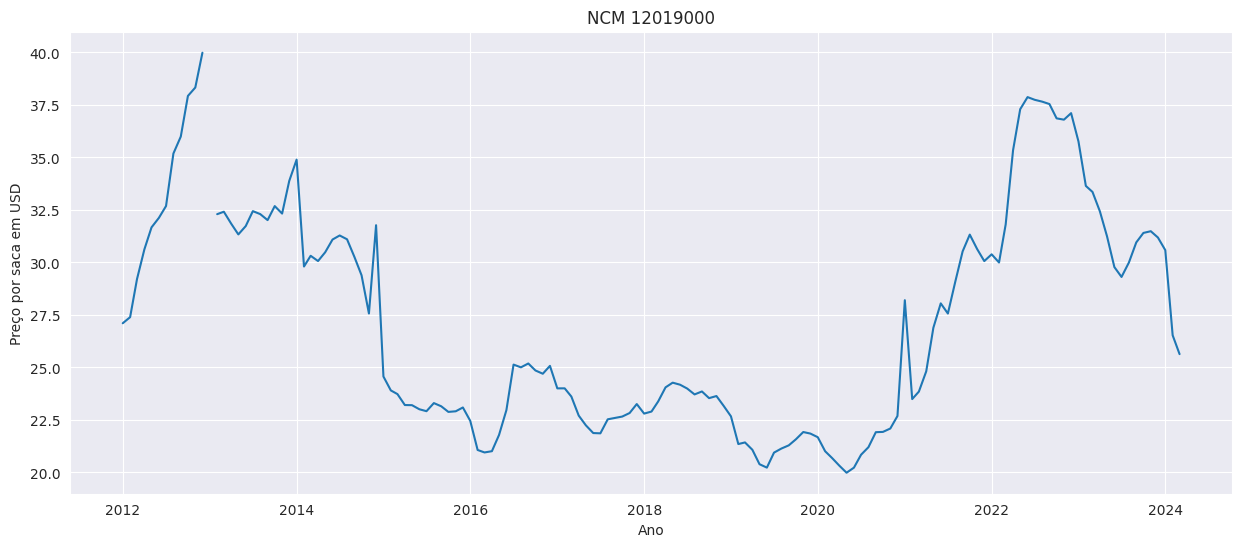

In [52]:
df_filtered = teste_fill[teste_fill['CO_NCM'] == 12019000]
df_filtered['DATE'] = (df_filtered['CO_ANO'] * 100) + df_filtered['CO_MES']
df_filtered['DATE'] = pd.to_datetime(df_filtered['DATE'], format='%Y%m')

plt.figure(figsize=(15, 6))
plt.plot(df_filtered['DATE'], df_filtered['PRECO_KG'] * 60)

# Add title and labels
plt.title('NCM 12019000')
plt.xlabel('Ano')
plt.ylabel('Preço por saca em USD')

# Show the plot
plt.show()


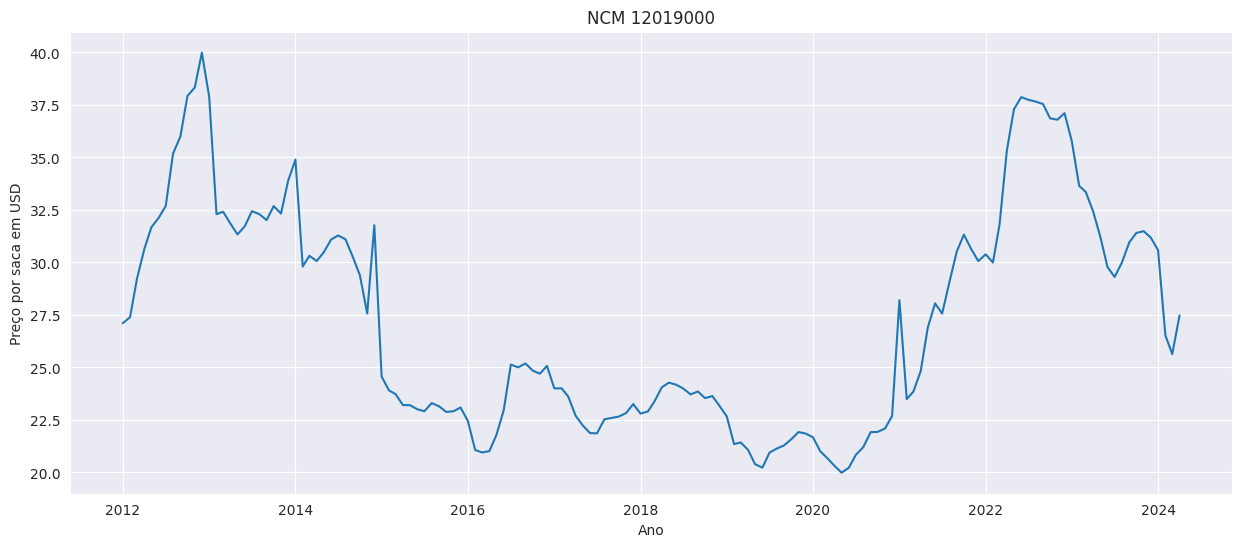

In [53]:
# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(df_filtered['DATE'], df_filtered['PRECO_GERADO'] * 60)

# Add title and labels
plt.title('NCM 12019000')
plt.xlabel('Ano')
plt.ylabel('Preço por saca em USD')

# Show the plot
plt.show()

Gráfico com informações reais do CEPEA\
Fonte: https://www.cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx

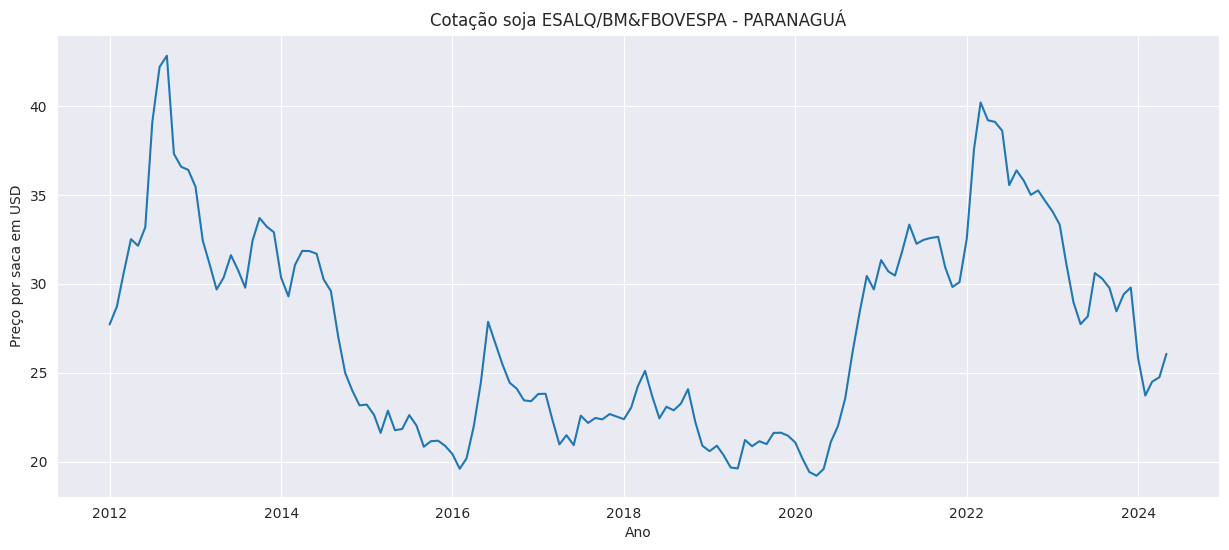

In [54]:
#Grafico soja ESALQ/CEPEA

cepea = pd.read_csv("cepea.csv", sep=',', encoding='utf-8')
cepea['DATA'] = pd.to_datetime(cepea['DATA'], format='%m/%Y')
cepea['PRECO_BRL'] = cepea['PRECO_BRL'].str.replace(',', '.').astype(float)
cepea['PRECO_USD'] = cepea['PRECO_USD'].str.replace(',', '.').astype(float)
cepea = cepea[cepea['DATA'] > '2011-12-01']
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(cepea['DATA'], cepea['PRECO_USD'])

plt.title('Cotação soja ESALQ/BM&F BOVESPA - PARANAGUÁ')
plt.xlabel('Ano')
plt.ylabel('Preço por saca em USD')

plt.show()

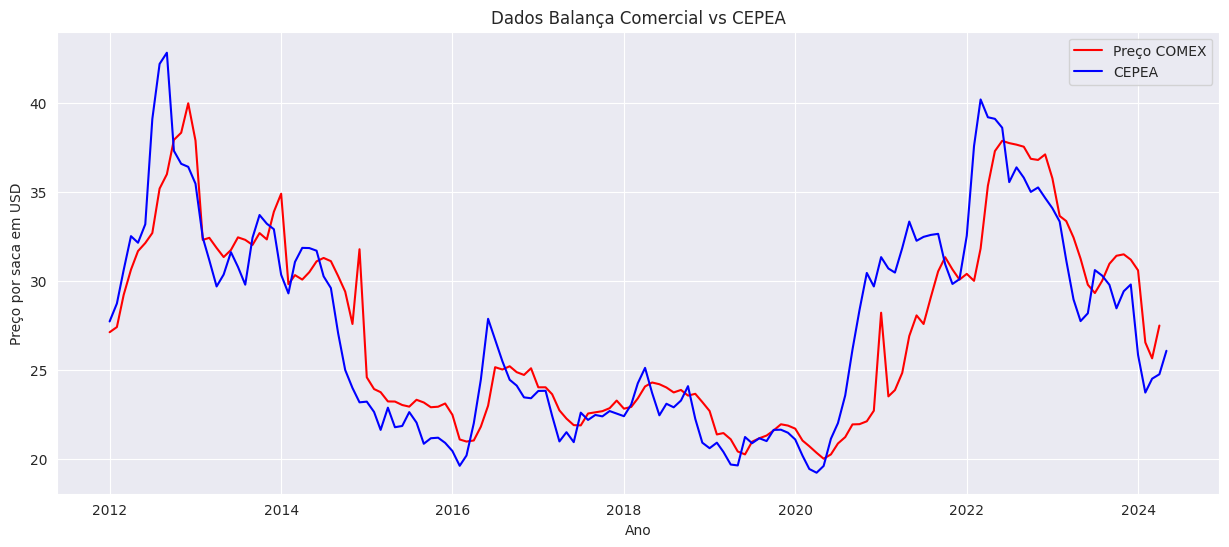

In [55]:
#Plot gerados vs CEPEA

plt.figure(figsize=(15, 6))

plt.plot(df_filtered['DATE'], df_filtered['PRECO_GERADO'] * 60, label='Preço COMEX', color='red')
plt.plot(cepea['DATA'], cepea['PRECO_USD'], label='CEPEA', color='blue')

plt.title('Dados Balança Comercial vs CEPEA')
plt.xlabel('Ano')
plt.ylabel('Preço por saca em USD')
plt.legend()
plt.show()

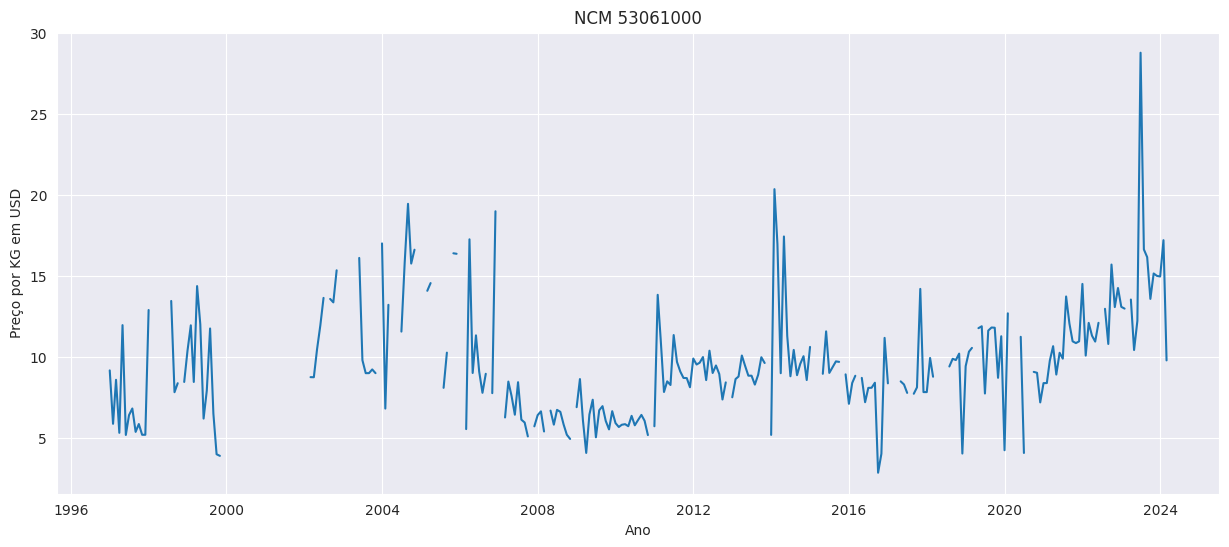

In [56]:
df_filtered = linho_fill[linho_fill['CO_NCM'] == 53061000]
df_filtered['DATE'] = (df_filtered['CO_ANO'] * 100) + df_filtered['CO_MES']
df_filtered['DATE'] = pd.to_datetime(df_filtered['DATE'], format='%Y%m')

plt.figure(figsize=(15, 6))
plt.plot(df_filtered['DATE'], df_filtered['PRECO_KG'])

# Add title and labels
plt.title('NCM 53061000')
plt.xlabel('Ano')
plt.ylabel('Preço por KG em USD')

# Show the plot
plt.show()

Vamos verificar o dataframe pois o gráfico acaba omitindo certos dados existentes, como por exemplo entre 2000 e 2002

In [57]:
df_filtered[(df_filtered['CO_NCM'] == 53061000)]

,CO_ANO,CO_MES,CO_NCM,NO_NCM_POR,KG_LIQUIDO,PRECO_KG,PRECO_GERADO,VL_FOB,Preenchido/Previsto,DATE
1,1997,1,53061000,"Fios de linho, simples",19530.0,9.170251,9.170251,179095.0,Não,1997-01-01
11,1997,2,53061000,"Fios de linho, simples",134603.0,5.876110,5.876110,790942.0,Não,1997-02-01
21,1997,3,53061000,"Fios de linho, simples",24563.0,8.589952,8.589952,210995.0,Não,1997-03-01
31,1997,4,53061000,"Fios de linho, simples",141826.0,5.320153,5.320152,754536.0,Não,1997-04-01
41,1997,5,53061000,"Fios de linho, simples",1620.0,11.961111,11.961111,19377.0,Não,1997-05-01
...,...,...,...,...,...,...,...,...,...,...
3231,2023,12,53061000,"Fios de linho, simples",16569.0,15.000000,15.000000,248535.0,Não,2023-12-01
3241,2024,1,53061000,"Fios de linho, simples",16819.0,14.959867,14.959867,251610.0,Não,2024-01-01
3251,2024,2,53061000,"Fios de linho, simples",7800.0,17.200000,17.200001,134160.0,Não,2024-02-01
3261,2024,3,53061000,"Fios de linho, simples",1456.0,9.787088,9.787087,14250.0,Não,2024-03-01


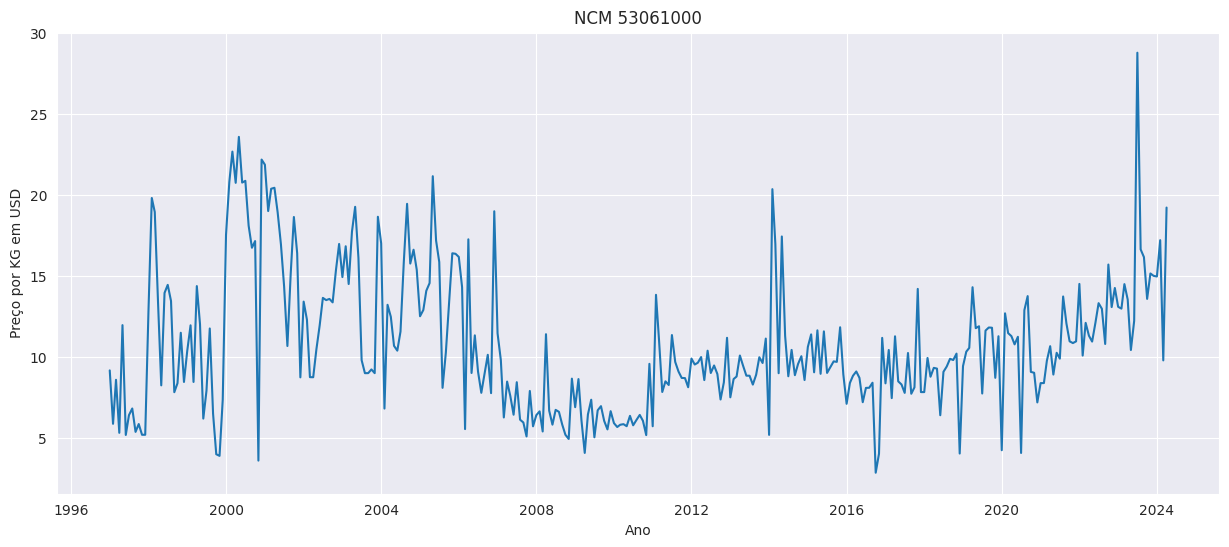

In [58]:
# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(df_filtered['DATE'], df_filtered['PRECO_GERADO'])

# Add title and labels
plt.title('NCM 53061000')
plt.xlabel('Ano')
plt.ylabel('Preço por KG em USD')

# Show the plot
plt.show()

Analise concluída, vamos assumir a coluna gerada como principal

In [59]:
dados = teste_fill
linho = linho_fill
dados = dados.drop(columns={'PRECO_KG'})
linho = linho.drop(columns={'PRECO_KG'})
dados = dados.rename(columns={'PRECO_GERADO': 'PRECO_KG'})
linho = linho.rename(columns={'PRECO_GERADO': 'PRECO_KG'})

Computador não tem ram infinita, hora do free()

In [60]:
teste_fill = []
linho_fill = []
df_filtered = []
del teste_fill
del linho_fill
del df_filtered

In [61]:
#função de erro WMAPE
from typing import Union

class WMAPE(torch.nn.Module):

    def __init__(self):
        super(WMAPE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = [""]
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return y_hat.squeeze(-1)

    def __call__(
            self,
            y: torch.Tensor,
            y_hat: torch.Tensor,
            mask: Union[torch.Tensor, None] = None,
    ):
        if mask is None:
            mask = torch.ones_like(y_hat)

        num = mask * (y - y_hat).abs()
        den = mask * y.abs()
        return num.sum() / den.sum()

In [62]:
#WMAPE
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

Vamos prever com Seasonal AutoRegressive Integrated Moving Average (SARIMA) para testes

In [63]:
def DatasetARIMA(DataF):
    DS = DataF.copy()
    DS['DATE'] = (DS['CO_ANO'] * 100) + DS['CO_MES']
    DS['DATE'] = pd.to_datetime(DS['DATE'], format='%Y%m')
    DS.drop(['CO_ANO', 'CO_MES'], axis=1, inplace=True)
    DS = DS.rename(columns={'DATE': 'ds', 'PRECO_KG': 'y'})
    DS.drop(['NO_NCM_POR', 'KG_LIQUIDO' ,'VL_FOB', 'Preenchido/Previsto'], axis=1, inplace=True)
    return DS

In [64]:
ArimaSoja = DatasetARIMA(dados)

In [65]:
ArimaLinho = DatasetARIMA(linho)

In [66]:
ArimaSoja

,CO_NCM,y,ds
0,12019000,0.451748,2012-01-01
1,12019000,0.456592,2012-02-01
2,12019000,0.486842,2012-03-01
3,12019000,0.510402,2012-04-01
4,12019000,0.527838,2012-05-01
...,...,...,...
143,12019000,0.519796,2023-12-01
144,12019000,0.509768,2024-01-01
145,12019000,0.442186,2024-02-01
146,12019000,0.427259,2024-03-01


In [67]:
ArimaLinho

,CO_NCM,y,ds
4,12040090,-0.375002,1997-01-01
14,12040090,0.380000,1997-02-01
24,12040090,0.242412,1997-03-01
34,12040090,0.344994,1997-04-01
44,12040090,0.600000,1997-05-01
...,...,...,...
3239,63025910,13.910045,2023-12-01
3249,63025910,29.257010,2024-01-01
3259,63025910,14.752288,2024-02-01
3269,63025910,26.876373,2024-03-01


In [68]:
cepea #saca de soja

,DATA,PRECO_BRL,PRECO_USD
70,2012-01-01,49.55,27.71
71,2012-02-01,49.32,28.72
72,2012-03-01,54.93,30.61
73,2012-04-01,60.35,32.51
74,2012-05-01,63.79,32.14
...,...,...,...
214,2024-01-01,126.93,25.83
215,2024-02-01,117.64,23.71
216,2024-03-01,121.91,24.49
217,2024-04-01,126.79,24.74


In [69]:
import pmdarima as pm
previsoesArima = pd.DataFrame()
for j in ArimaLinho['CO_NCM'].unique():
    DS = ArimaLinho[ArimaLinho['CO_NCM'] == j].copy().reset_index() 
    SARIMA_teste = pm.auto_arima(DS[DS['ds'] < '2023-01-01']['y'],
                                 start_p=1, start_q=1,
                                 test='adf',
                                 max_p=6, max_q=6, m=12, #6 meses de lag
                                 start_P=0, start_Q= 0,
                                 max_P=6, max_Q=6,
                                 seasonal=True,
                                 d=None, D = 1,
                                 trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True, n_fits = 60)

    predicaoPreco = SARIMA_teste.predict(n_periods=12, return_conf_int=False) 
    predicaoPreco = predicaoPreco.to_numpy().reshape(-1)
    val = ArimaLinho[(ArimaLinho['ds'].dt.year == 2023) & (ArimaLinho['CO_NCM'] == j)].to_numpy()
    val = val[:, 1].reshape(-1)
    data = {
        'CO_NCM': j,
        'ds': pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS'),
        'PRECO_PREVISTO' : predicaoPreco
    }

    df = pd.DataFrame(data, index=range(1, 13))
    previsoesArima = pd.concat([df, previsoesArima])
    print(f'NCM: {j},  WMAPE: {wmape(val, predicaoPreco)}')

previsoesArima = previsoesArima.sort_values(by=['CO_NCM', 'ds']) #precisamos ordenar por NCM

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=301.484, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=347.774, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=268.803, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=345.814, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=323.691, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=240.857, Time=0.77 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=227.481, Time=1.81 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=219.031, Time=3.54 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=218.734, Time=5.18 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=215.354, Time=11.16 sec
 ARIMA(1,0,0)(6,1,1)[12] intercept   : AIC=inf, Time=25.95 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=17.15 sec
 ARIMA(0,0,0)(6,1,0)[12] intercept   : AIC=256.913, Time=5.18 sec
 ARIMA(2,0,0)(6,1,0)[12] intercept   : AIC

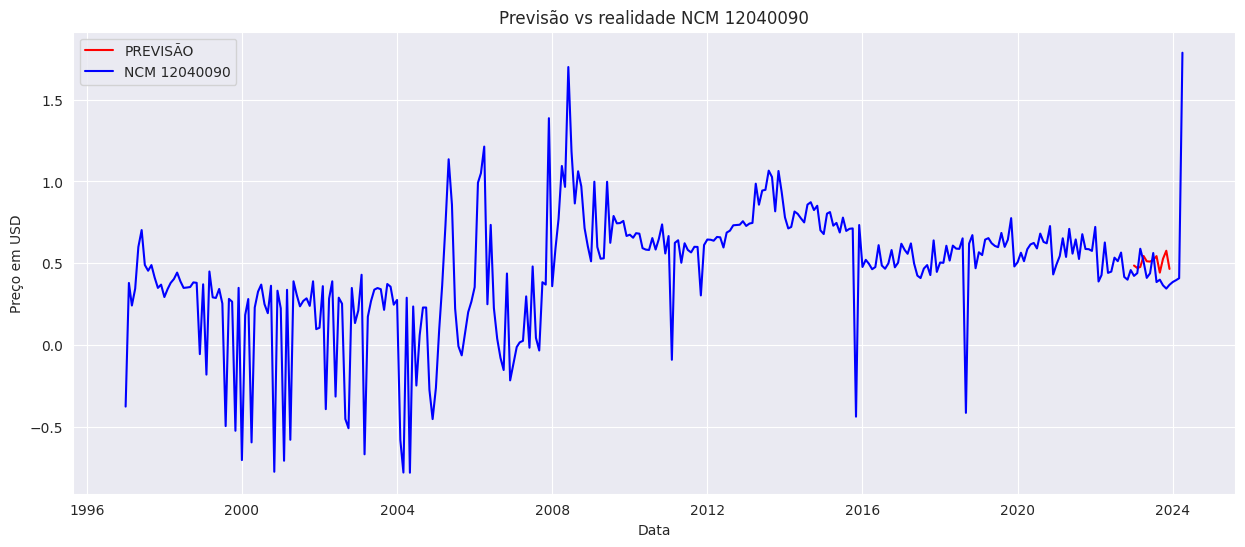

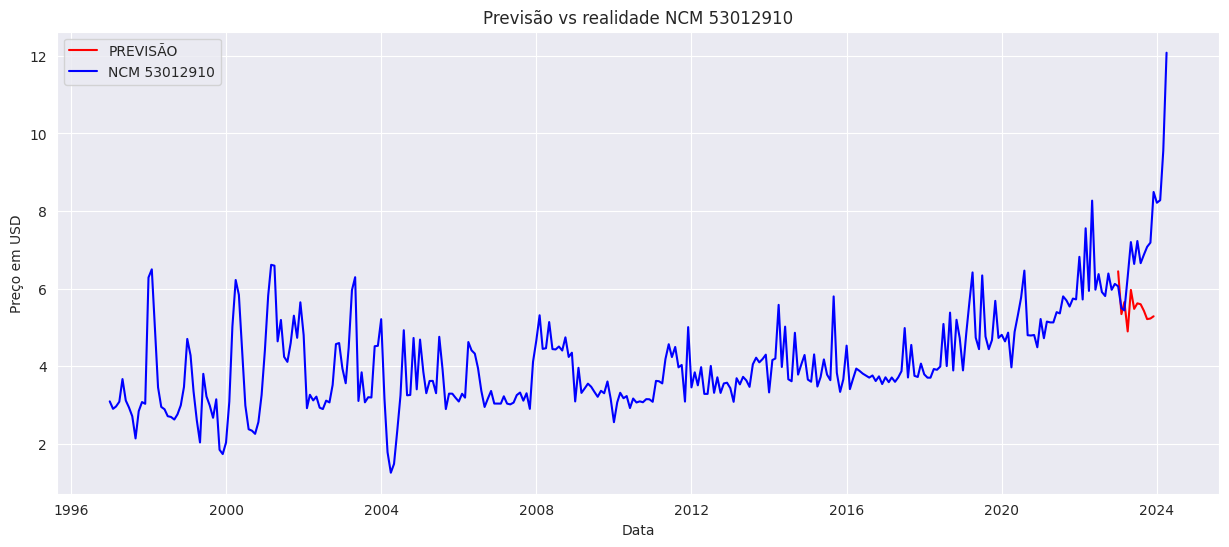

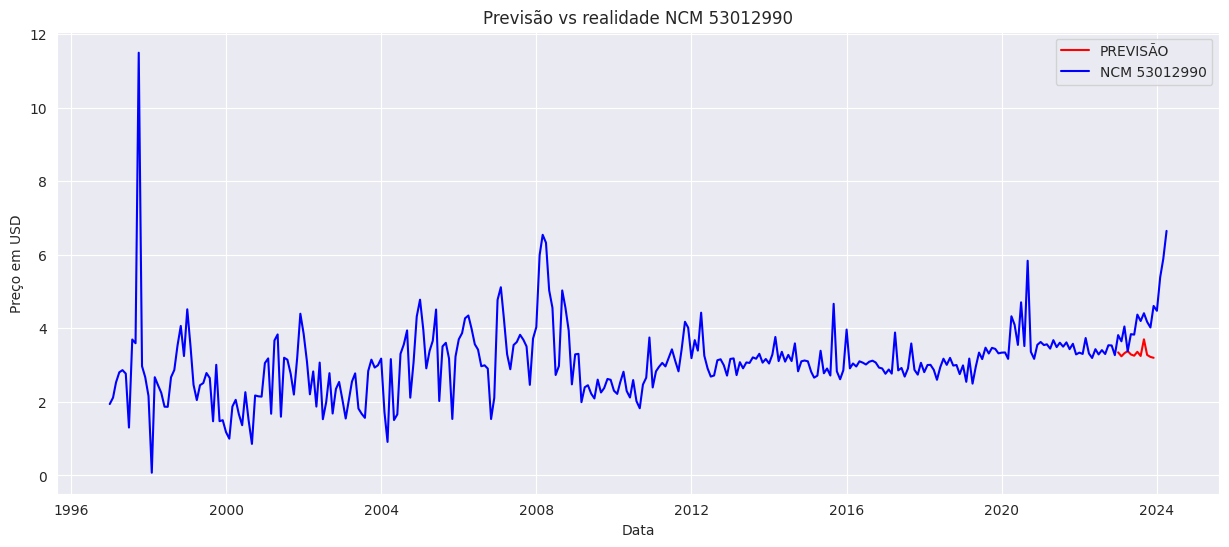

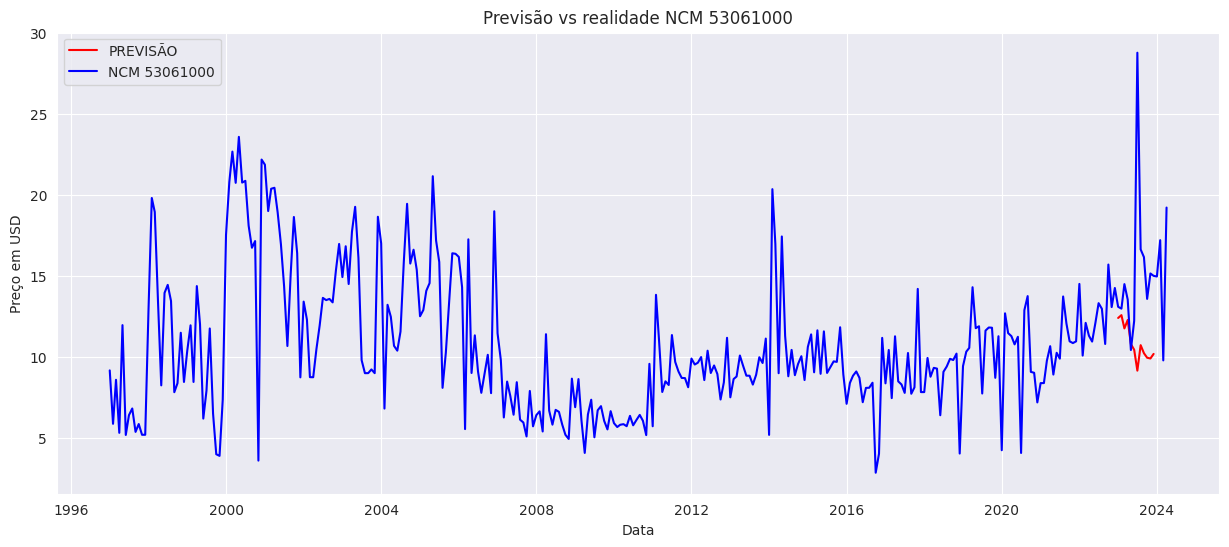

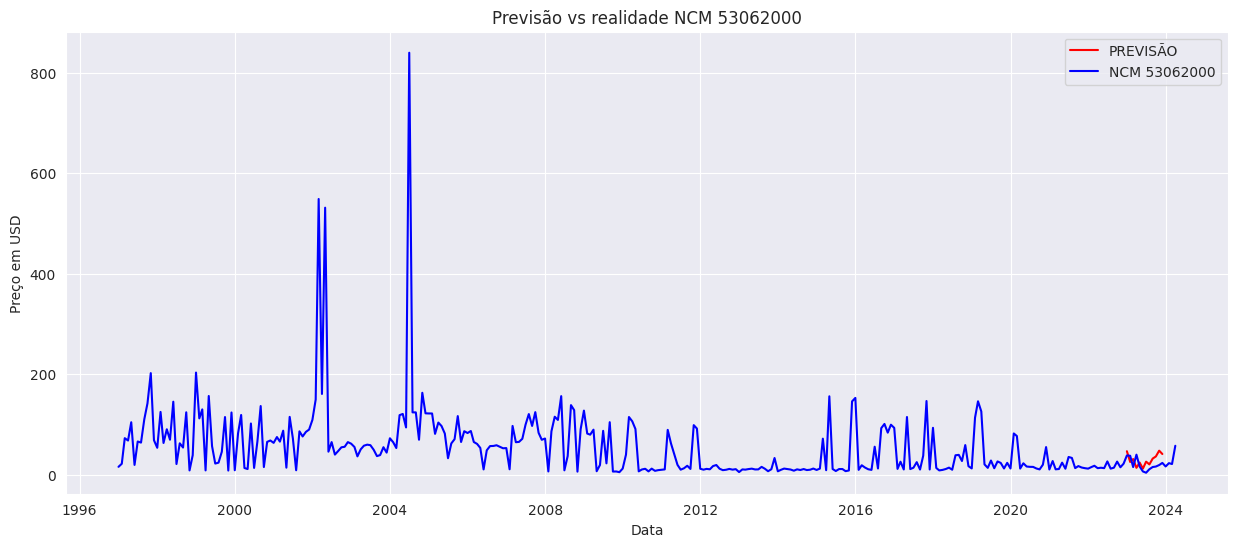

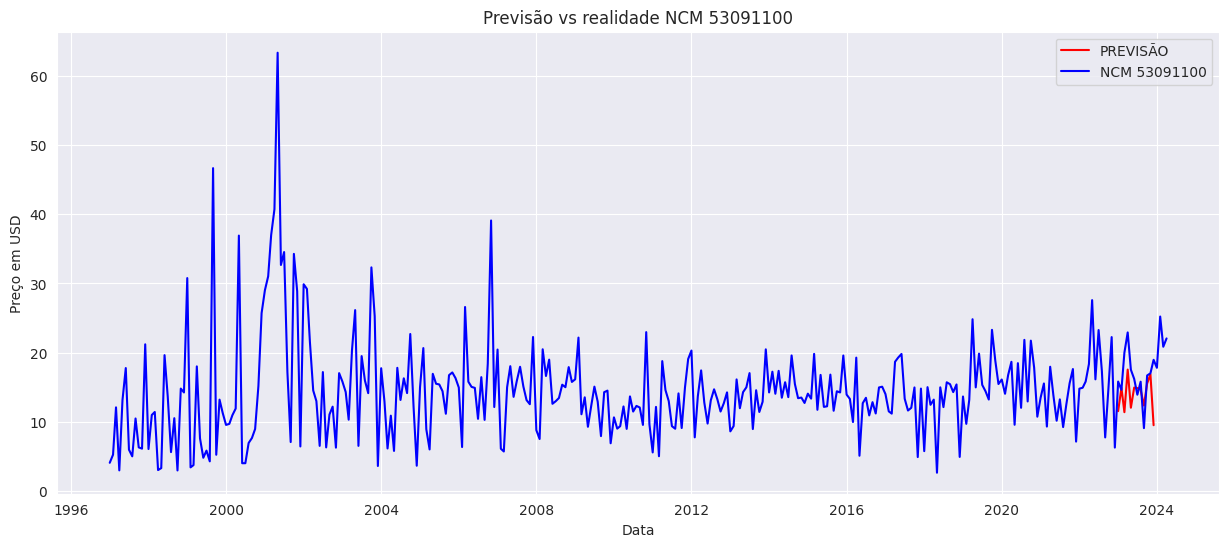

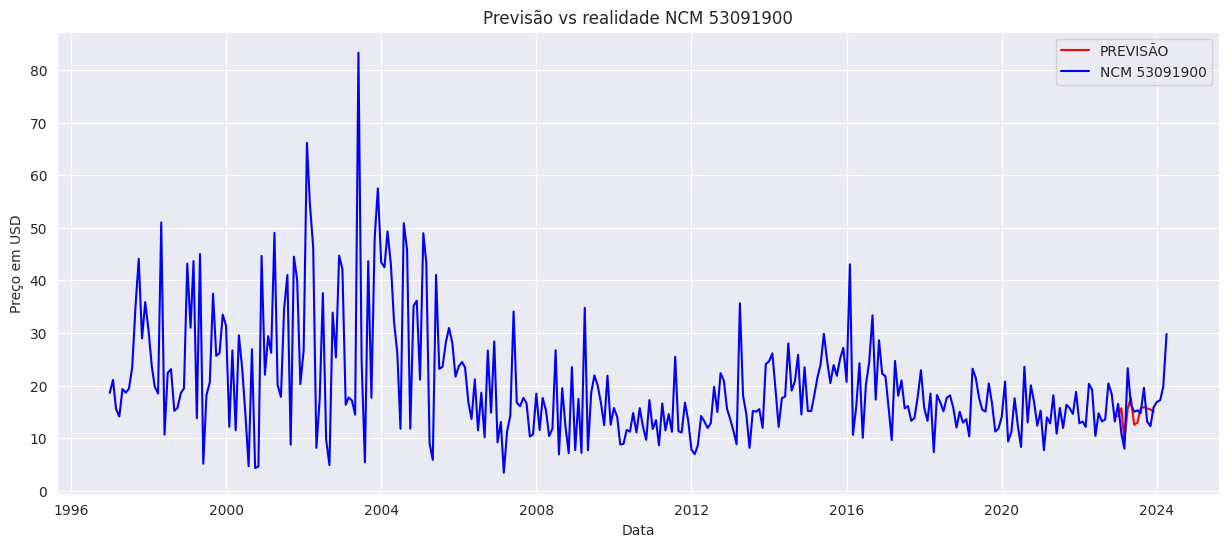

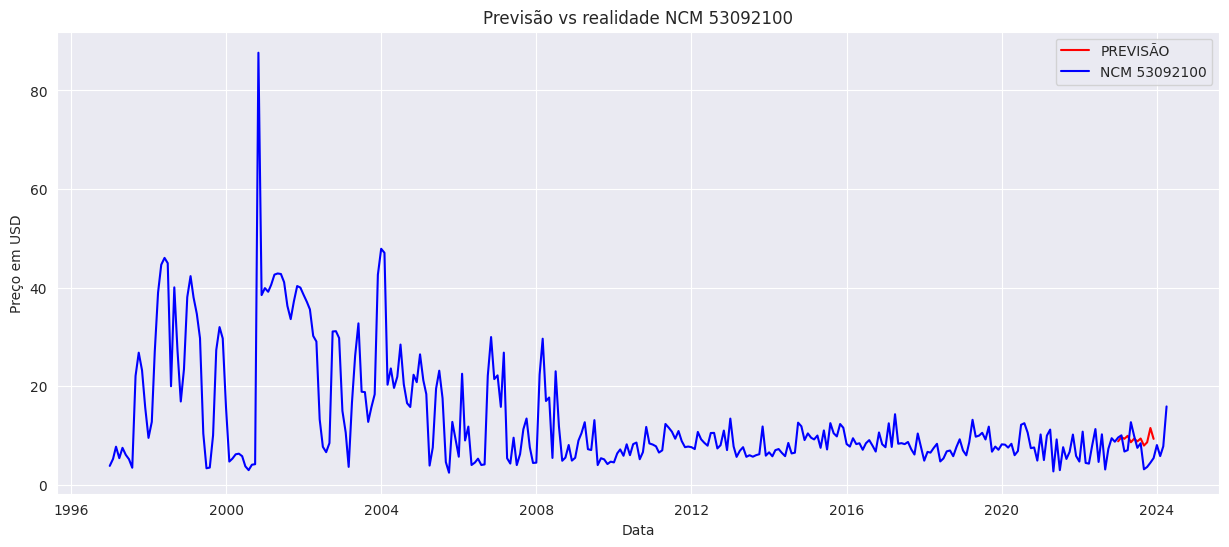

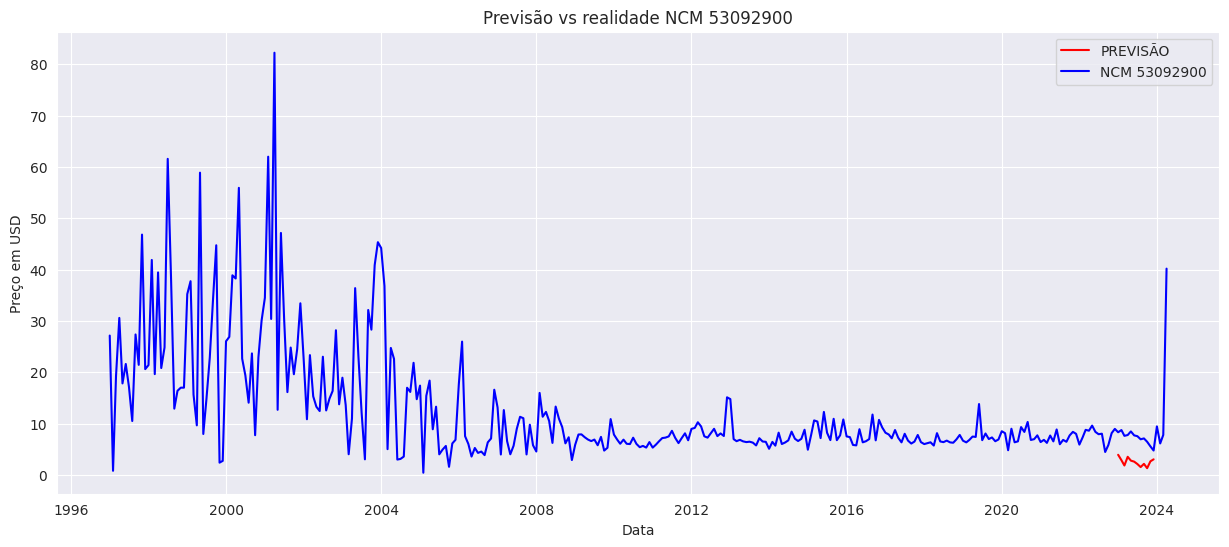

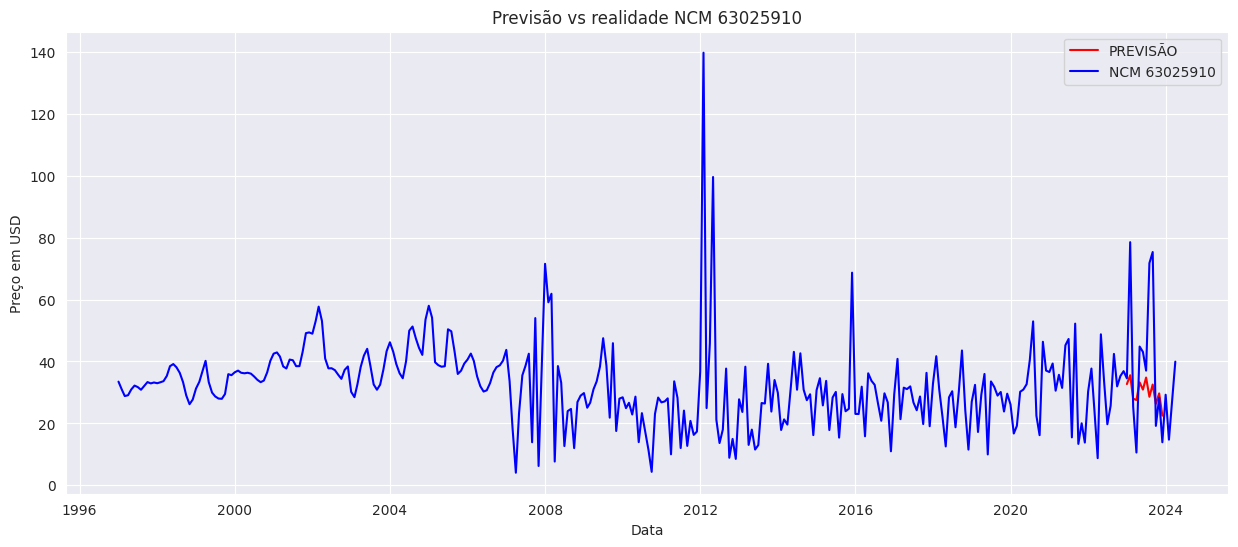

In [70]:
for ncm in ArimaLinho['CO_NCM'].unique():
    # Filter previsoesArima for the current CO_NCM
    df_filtered = previsoesArima[previsoesArima['CO_NCM'] == ncm]
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(df_filtered['ds'], df_filtered['PRECO_PREVISTO'], label='PREVISÃO', color = 'red')
    plt.plot(ArimaLinho[ArimaLinho['CO_NCM'] == ncm]['ds'], ArimaLinho[ArimaLinho['CO_NCM'] == ncm]['y'], label=f'NCM {ncm}', color='blue')

    # Adding title, labels, and legend
    plt.title(f'Previsão vs realidade NCM {ncm}')
    plt.xlabel('Data')
    plt.ylabel('Preço em USD')
    plt.legend()

    # Display the plot
    plt.show()


In [71]:
DS = ArimaSoja.copy() #copia dos dados previamente preenchidos

SARIMA_teste = pm.auto_arima(DS[DS['ds']< '2023-01-01']['y'],
                             start_p=1, start_q=1,
                             test='adf',
                             max_p=6, max_q=6, m=12,
                             start_P=0, start_Q=0, seasonal=True,
                             max_P=6, max_Q=6,
                             d=None, D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True, n_fits = 60)

predicaoPreco = SARIMA_teste.predict(n_periods=12, return_conf_int=False)


#será validado com os dados reais do CEPEA, ano 2023
dscepea = cepea[(cepea['DATA'] >= '2023-01-01') & (cepea['DATA'] <= '2023-12-01')]
dscepea = dscepea.drop(['PRECO_BRL', 'DATA'], axis=1)
dscepea['PRECO_USD'] = dscepea['PRECO_USD'] / 60 #preço por kg pelo CEPEA
predicaoPreco = predicaoPreco.to_numpy().reshape(-1)
dscepea = dscepea.to_numpy().reshape(-1)
print('WMAPE:', wmape(dscepea, predicaoPreco))
predicaoPreco

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-495.581, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-493.009, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-525.431, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-535.229, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-495.318, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-533.503, Time=1.04 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-533.477, Time=1.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-525.086, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-531.514, Time=2.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-536.155, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-534.530, Time=0.38 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-534.487, Time=0.93 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-526.085, Time=0.08 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-532.532, Time=0.93 sec
 ARIMA(1,1,0)(0,1,1

array([0.62971868, 0.60305438, 0.61265755, 0.63001506, 0.64429822,
       0.65182275, 0.65423217, 0.66113863, 0.66744504, 0.6673419 ,
       0.66519157, 0.66922729])

In [72]:
predicaoPreco = pd.DataFrame(predicaoPreco, columns=['PRECO_PREVISTO'])
predicaoPreco['DATA'] = pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS')

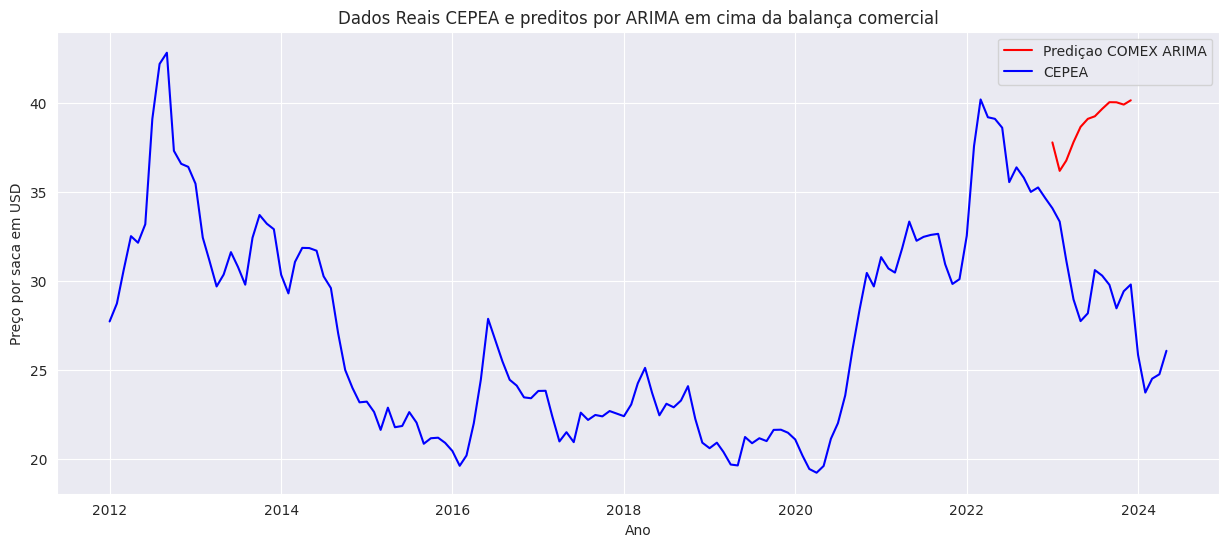

In [73]:
#Plot gerados vs CEPEA

plt.figure(figsize=(15, 6))

plt.plot(predicaoPreco['DATA'], predicaoPreco['PRECO_PREVISTO'] * 60, label='Prediçao COMEX ARIMA', color='red')
plt.plot(cepea['DATA'], cepea['PRECO_USD'], label='CEPEA', color='blue')

plt.title('Dados Reais CEPEA e preditos por ARIMA em cima da balança comercial')
plt.xlabel('Ano')
plt.ylabel('Preço por saca em USD')
plt.legend()
plt.show()

Pelo que podemos ver acima, o SARIMA se saiu muito mal, os dados são muito voláteis

## Bora de Ensemble

In [564]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

Aparentemente terá que ser criado um modelo para cada NCM\
Não há necessidade de manter NCM no dataset de treino

In [565]:
def FeaturesPreco(ds):
    DS = ds.copy()
    DS.rename(columns={'CO_ANO': 'year', 'CO_MES': 'month', 'PRECO_KG': 'y'}, inplace=True)
    DS['ds'] = (DS['year'] * 100) + DS['month']
    DS['ds'] = pd.to_datetime(DS['ds'], format='%Y%m')
    DS['trimestre'] = DS['ds'].dt.quarter
    DS.drop(['year','CO_NCM', 'NO_NCM_POR', 'KG_LIQUIDO', 'VL_FOB', 'Preenchido/Previsto'], axis=1, inplace=True)
    DS.set_index('ds', inplace=True)
    DS['data'] = DS.index.to_series()
    return DS 

In [566]:
def FeaturesVol(ds):
    DS = ds.copy()
    DS.rename(columns={'CO_ANO': 'year', 'CO_MES': 'month', 'KG_LIQUIDO': 'y'}, inplace=True)
    DS['ds'] = (DS['year'] * 100) + DS['month']
    DS['ds'] = pd.to_datetime(DS['ds'], format='%Y%m')
    DS['trimestre'] = DS['ds'].dt.quarter
    DS.drop(['year','CO_NCM','NO_NCM_POR', 'PRECO_KG', 'VL_FOB', 'Preenchido/Previsto'], axis=1, inplace=True)
    DS.set_index('ds', inplace=True)
    DS['data'] = DS.index.to_series()
    return DS 

In [567]:
from copy import deepcopy as dc
def Lags(DF, quant):
    DS = dc(DF)
    
    for i in range(1, quant + 1):
        DS[f'lag{i}'] = DS['y'].shift(i * 12)
   
    return DS

In [720]:
def Treinar(DS, Unidade):
    
    tss = TimeSeriesSplit(n_splits=4, test_size=12, gap=0)
    preds = []
    scores = []

    parameters = {
        "boosting": ['gbdt'],
        "num_leaves": [12],
        #"objective": ['multiclass'],
        "max_depth": [4],
        "learning_rate": [0.3],
        "n_estimators": [1000],
        "colsample_bytree": [0.1],
        "early_stopping_rounds": [10],
    }

    df = DS.copy() #pra nao precisar mudar tudo

    for train_index, val_index in tss.split(df):
        train = df.iloc[train_index]
        test = df.iloc[val_index]
    
        #ou features peso
        if Unidade == 'Preco':
            train = FeaturesPreco(train)
            test = FeaturesPreco(test)
        elif Unidade == 'Volume':
            train = FeaturesVol(train)
            test = FeaturesVol(test)
            
            
        train = Lags(train, 4) #4 anos de lag
        test = Lags(test, 4) #4 anos de lag


        FEATURES = ['month', 'trimestre', 'lag1', 'lag2', 'lag3', 'lag4'] #sem o ano saiu melhor
        TARGET = 'y'
        X_train = train[FEATURES]
        y_train = train[TARGET] #OBS: podem ser os dados reais do CEPEA no caso da soja
        X_test = test[FEATURES]
        y_test = test[TARGET]
    
       #reg = XGBRegressor(base_score=0.5, booster='gbtree',
                           #n_estimators = 1000, early_stopping_rounds = 500,
                           #learning_rate = 0.01, max_depth = 8,
                           #n_jobs = -1, objective = 'reg:linear')
        #reg = XGBRegressor()
        reg = lgb.LGBMRegressor()

        grid_search = GridSearchCV(reg, parameters, cv=tss, n_jobs=-1)
    
        grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
        y_pred = grid_search.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
        
    return grid_search, preds, scores 
        

In [685]:
grid_search, preds, scores = Treinar(dados, 'Preco')

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Start training from score 0.436148
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [686]:
scores

[0.0936647363853398,
 0.035688111787015045,
 0.049660225713373245,
 0.031381250048669124]

In [687]:
grid_search.best_params_

{'boosting': 'gbdt',
 'colsample_bytree': 0.1,
 'early_stopping_rounds': 10,
 'learning_rate': 0.3,
 'max_depth': 4,
 'n_estimators': 100,
 'num_leaves': 12}

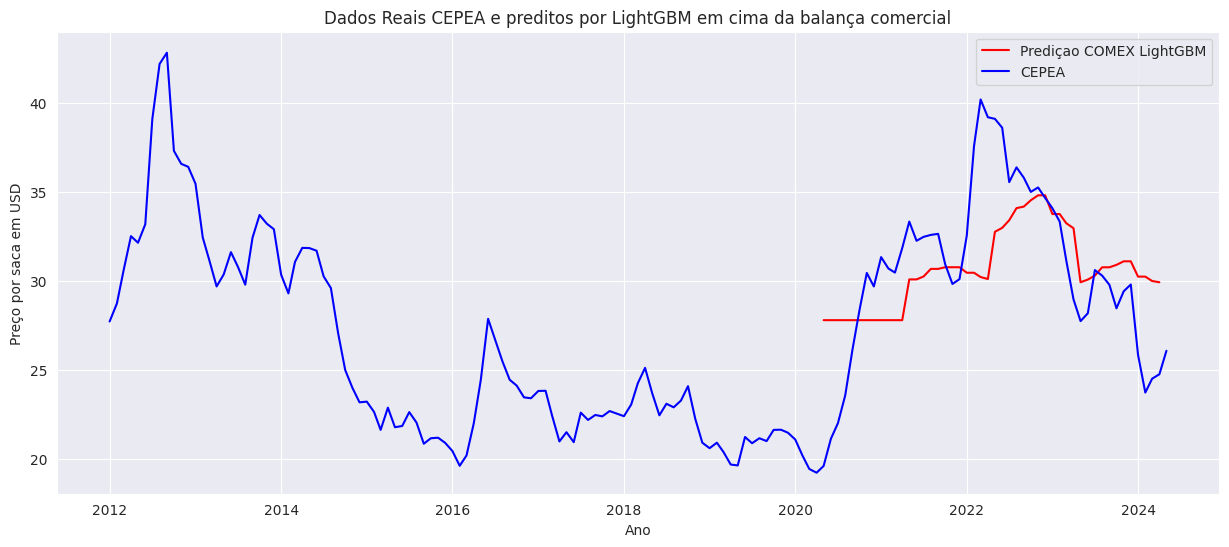

In [688]:
#Plot gerados vs CEPEA
preds = np.array(preds).reshape(-1)
preds = pd.DataFrame(preds, columns=['PRECO_PREVISTO'])
preds['DATA'] = pd.date_range(start='2020-05-01', end='2024-04-30', freq='MS')

plt.figure(figsize=(15, 6))

plt.plot(preds['DATA'],preds['PRECO_PREVISTO'] * 60, label='Prediçao COMEX LightGBM', color='red')
plt.plot(cepea['DATA'], cepea['PRECO_USD'], label='CEPEA', color='blue')

plt.title('Dados Reais CEPEA e preditos por LightGBM em cima da balança comercial')
plt.xlabel('Ano')
plt.ylabel('Preço por saca em USD')
plt.legend()
plt.show()

## Previsões para soja

In [661]:
df = dados.copy() #pra nao precisar mudar tudo
df = FeaturesPreco(df)
df = Lags(df, 4) #4 anos de lag

FEATURES = ['month', 'trimestre', 'lag1', 'lag2', 'lag3'] #sem o ano saiu melhor
TARGET = 'y'

parameters = {
    "boosting": ['gbdt'],
    "num_leaves": [12],
    #"objective": ['multiclass'],
    "max_depth": [4],
    "learning_rate": [0.3],
    "n_estimators": [100],
    "colsample_bytree": [0.1],
    "early_stopping_rounds": [10],
}

X_all = df[FEATURES]
y_all = df[TARGET]

#reg = XGBRegressor(base_score=0.5, booster='gbtree', n_estimators = 500,
                   #objective = 'reg:linear', n_jobs = -1, max_depth = 3,
                   #learning_rate = 0.01)

#reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose=100)

reg = lgb.LGBMRegressor()

grid_search = GridSearchCV(reg, parameters, cv=tss, n_jobs=-1)

grid_search.fit(X_all, y_all, eval_set=[(X_all, y_all)])
#y_pred = grid_search.predict(X_all)


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=12),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting': ['gbdt'], 'colsample_bytree': [0.1],
                         'early_stopping_rounds': [10], 'learning_rate': [0.3],
                         'max_depth': [4], 'n_estimators': [100],
                         'num_leaves': [12]})

Dataset futuro:

In [662]:
from datetime import date
from dateutil.relativedelta import relativedelta
dataPrevisao = dados.copy()

futuro = pd.date_range(start= df.index.max() + relativedelta(months = 1), end= df.index.max() + relativedelta(months = 12), freq='MS')
df_futuro['ds'] = futuro
df_futuro.set_index('ds', inplace=True)
df_futuro['data'] = df_futuro.index.to_series()
df_futuro['ehFuturo'] = True
df_futuro['month'] = df_futuro['data'].dt.month
df_futuro['trimestre'] = df_futuro['data'].dt.quarter
dataPrevisao['ehFuturo'] = False
dataPrevisao = FeaturesPreco(dataPrevisao)
dataPrevisao = pd.concat([dataPrevisao, df_futuro])
dataPrevisao = dataPrevisao.drop(['data'], axis=1)
dataPrevisao = Lags(dataPrevisao, 3)

In [663]:
futuroCaracteristicas = dataPrevisao.query('ehFuturo').copy()
futuroCaracteristicas = grid_search.predict(futuroCaracteristicas[FEATURES])

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [665]:
futuroCaracteristicas = pd.DataFrame(futuroCaracteristicas, columns=['PRECO_KG'])
futuroCaracteristicas['ds'] = futuro
futuroCaracteristicas

,PRECO_KG,ds
0,0.381131,2024-05-01
1,0.403323,2024-06-01
2,0.417497,2024-07-01
3,0.441842,2024-08-01
4,0.446506,2024-09-01
5,0.428158,2024-10-01
6,0.479038,2024-11-01
7,0.470615,2024-12-01
8,0.455970,2025-01-01
9,0.448447,2025-02-01


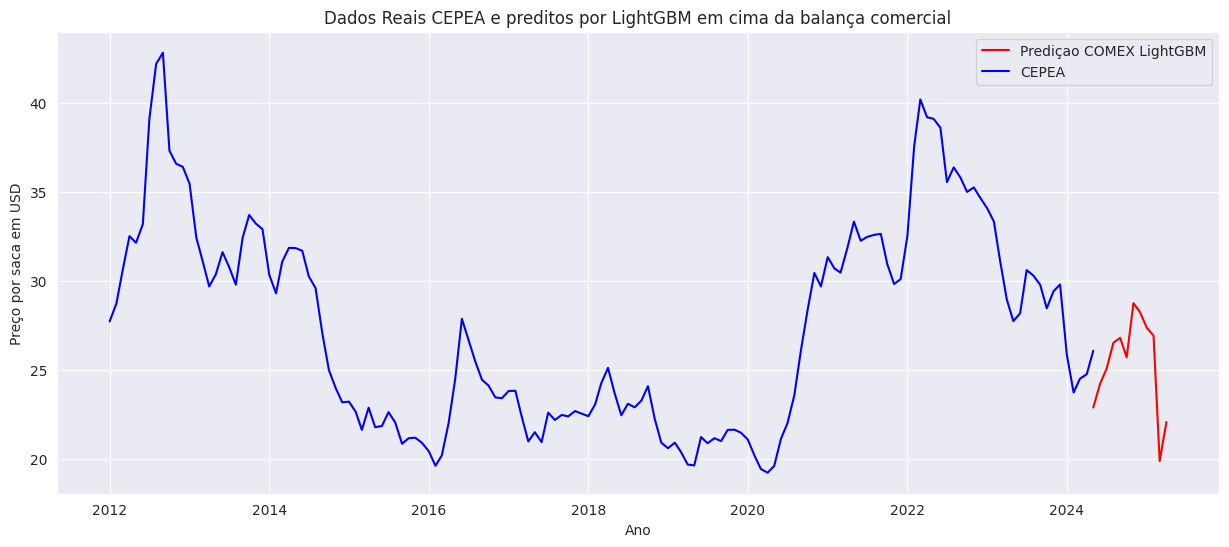

In [666]:
#Plot gerados vs CEPEA
#Plot gerados vs CEPEA


plt.figure(figsize=(15, 6))

plt.plot(futuroCaracteristicas['ds'] ,futuroCaracteristicas['PRECO_KG'] * 60, label='Prediçao COMEX LightGBM', color='red')
plt.plot(cepea['DATA'], cepea['PRECO_USD'], label='CEPEA', color='blue')

plt.title('Dados Reais CEPEA e preditos por LightGBM em cima da balança comercial')
plt.xlabel('Ano')
plt.ylabel('Preço por saca em USD')
plt.legend()
plt.show()

Previsão de volume de importações

In [724]:
grid_search, preds, scores = Treinar(dados, 'Volume')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Start training from score 4190480035.578948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [725]:
scores

[5774361554.192497, 4445028326.053806, 4197159895.966553, 5313259308.287348]

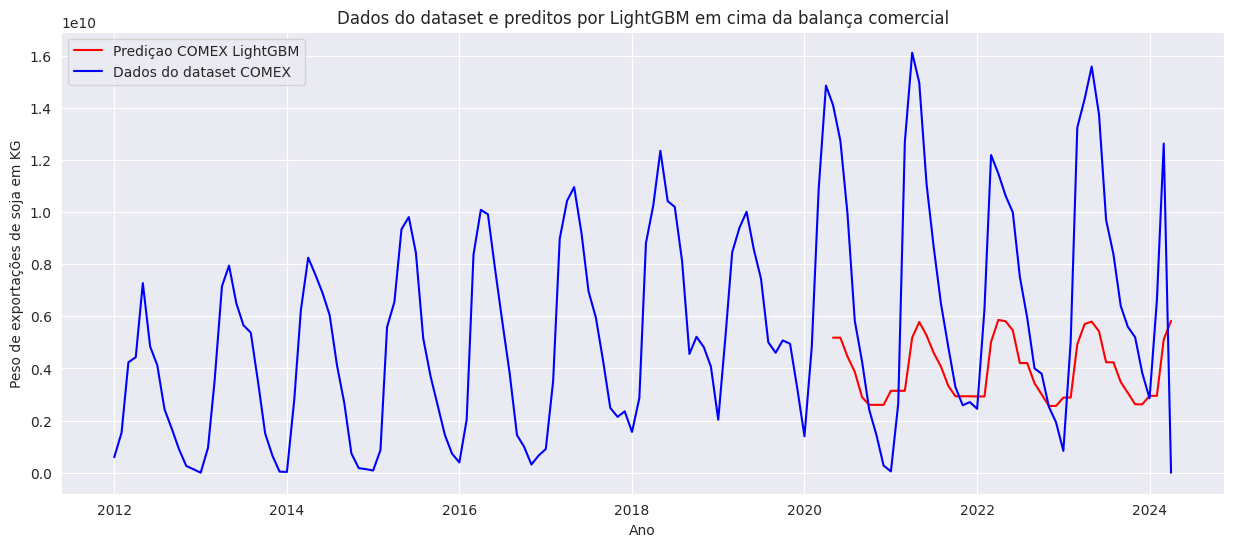

In [726]:
#Plot gerados vs CEPEA
preds = np.array(preds).reshape(-1)
preds = pd.DataFrame(preds, columns=['VOLUME_PREVISTO'])
preds['DATA'] = pd.date_range(start='2020-05-01', end='2024-04-30', freq='MS')
Data = pd.DataFrame()
Data['DATA'] = (dados['CO_ANO'] * 100) + dados['CO_MES']
Data['DATA'] = pd.to_datetime(Data['DATA'], format='%Y%m')


plt.figure(figsize=(15, 6))

plt.plot(preds['DATA'], preds['VOLUME_PREVISTO'], label='Prediçao COMEX LightGBM', color='red')
plt.plot(Data['DATA'], dados['KG_LIQUIDO'], label='Dados do dataset COMEX', color='blue')

plt.title('Dados do dataset e preditos por LightGBM em cima da balança comercial')
plt.xlabel('Ano')
plt.ylabel('Peso de exportações de soja em KG')
plt.legend()
plt.show()

## Previsões do volume de exportações de soja por ARIMA

In [727]:
ArimaSoja['y'] = dados['KG_LIQUIDO']

In [751]:
DS = ArimaSoja.copy() #copia dos dados previamente preenchidos

SARIMA_teste = pm.auto_arima(DS[DS['ds']< '2021-01-01']['y'],
                             start_p=1, start_q=1,
                             test='adf',
                             max_p=6, max_q=6, m=12,
                             start_P=0, start_Q=0, seasonal=True,
                             max_P=6, max_Q=6,
                             d=None, D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True, n_fits = 60)

predicaoPeso = SARIMA_teste.predict(n_periods=40, return_conf_int=False) # 2021 até hoje

predicaoPeso = predicaoPeso.to_numpy().reshape(-1)
val = ArimaSoja[(ArimaSoja['ds'].dt.year > 2020)]['y'].to_numpy()
print(f'WMAPE: {wmape(val, predicaoPeso)}')

predicaoPeso

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=4299.258, Time=0.02 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4363.487, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4288.557, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4309.315, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4370.429, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4298.920, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4283.491, Time=0.44 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=4285.463, Time=1.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=4285.335, Time=0.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=4284.894, Time=0.29 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=4286.999, Time=1.09 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4358.795, Time=0.28 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4282.124, Time=0.31 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=4288.335, Time=0.16 sec
 ARIMA(2,0,0)(3,1,0

array([7.16514759e+07, 4.05182317e+09, 1.10233325e+10, 1.46171501e+10,
       1.57663981e+10, 1.43081646e+10, 1.25640020e+10, 9.03883566e+09,
       6.26257490e+09, 5.20080481e+09, 4.14508705e+09, 2.83299880e+09,
       1.58935760e+09, 5.24879722e+09, 1.07146164e+10, 1.34808177e+10,
       1.43815551e+10, 1.31016420e+10, 1.16013885e+10, 8.49416187e+09,
       6.82355492e+09, 6.24306962e+09, 5.50051214e+09, 3.98062902e+09,
       2.54014516e+09, 6.10023048e+09, 1.19490104e+10, 1.53157241e+10,
       1.55918496e+10, 1.42809629e+10, 1.22572554e+10, 8.71384158e+09,
       6.96863293e+09, 5.83013816e+09, 4.95314659e+09, 3.59966866e+09,
       2.67741504e+09, 6.40937476e+09, 1.26579090e+10, 1.60360864e+10])

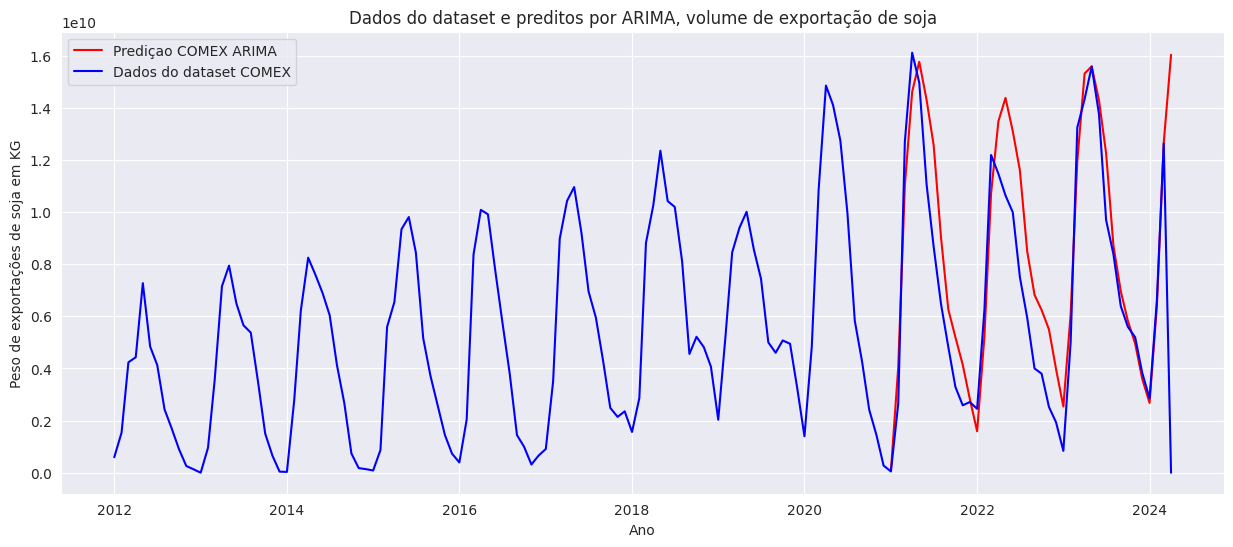

In [752]:
plt.figure(figsize=(15, 6))

PrevPeso = pd.DataFrame(predicaoPeso, columns=['KG_LIQUIDO'])
PrevPeso['DATA'] = pd.date_range(start='2021-01-01', end='2024-04-30', freq='MS')


plt.plot(PrevPeso['DATA'], PrevPeso['KG_LIQUIDO'], label='Prediçao COMEX ARIMA', color='red')
plt.plot(Data['DATA'], dados['KG_LIQUIDO'], label='Dados do dataset COMEX', color='blue')

plt.title('Dados do dataset e preditos por ARIMA, volume de exportação de soja')
plt.xlabel('Ano')
plt.ylabel('Peso de exportações de soja em KG')
plt.legend()
plt.show()

## A previsão do preço será por LightGBM, a do volume de exportação por ARIMA

In [753]:
DS = ArimaSoja.copy() #copia dos dados previamente preenchidos

SARIMA_teste = pm.auto_arima(DS[DS['ds']<= '2024-04-01']['y'],
                             start_p=1, start_q=1,
                             test='adf',
                             max_p=6, max_q=6, m=12,
                             start_P=0, start_Q=0, seasonal=True,
                             max_P=6, max_Q=6,
                             d=None, D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True, n_fits = 60)

predicao = SARIMA_teste.predict(n_periods=12, return_conf_int=False) # 2021 até hoje

predicao = predicao.to_numpy().reshape(-1)

Prev = pd.DataFrame(predicao, columns=['KG_LIQUIDO'])
Prev['DATA'] = pd.date_range(start='2024-05-01', end='2025-04-30', freq='MS')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=6182.274, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=6246.029, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=6170.198, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=6186.131, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=6249.384, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=6185.549, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=6171.591, Time=0.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=6171.587, Time=0.16 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=6170.556, Time=0.15 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=6172.080, Time=1.59 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=6231.826, Time=0.15 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=6166.819, Time=0.15 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=6179.315, Time=0.03 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=6167.086, Time=0.45 sec
 ARIMA(2,0,0)(1,1,1

In [754]:
Prev

,KG_LIQUIDO,DATA
0,1.423721e+08,2024-05-01
1,2.185799e+09,2024-06-01
2,2.801382e+09,2024-07-01
3,4.001265e+09,2024-08-01
4,3.858248e+09,2024-09-01
5,4.060828e+09,2024-10-01
6,3.832466e+09,2024-11-01
7,3.027692e+09,2024-12-01
8,2.165821e+09,2025-01-01
9,5.940609e+09,2025-02-01


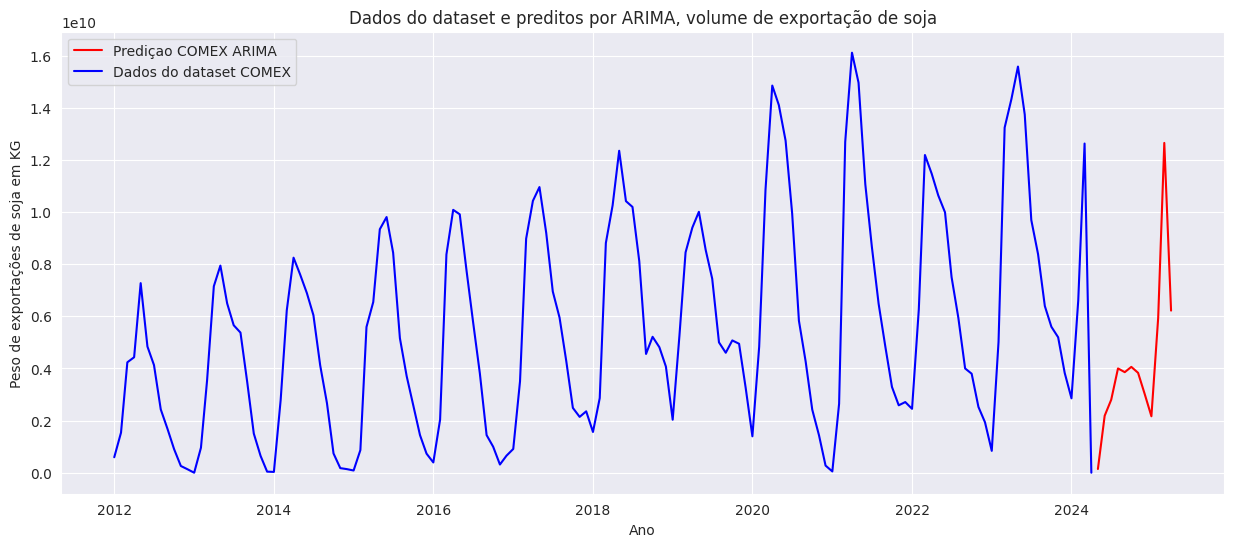

In [755]:
plt.figure(figsize=(15, 6))

plt.plot(Prev['DATA'], Prev['KG_LIQUIDO'], label='Prediçao COMEX ARIMA', color='red')
plt.plot(Data['DATA'], dados['KG_LIQUIDO'], label='Dados do dataset COMEX', color='blue')

plt.title('Dados do dataset e preditos por ARIMA, volume de exportação de soja')
plt.xlabel('Ano')
plt.ylabel('Peso de exportações de soja em KG')
plt.legend()
plt.show()

O plano inicial era também gerar modelos LightGBM para cada produto de linho e salvá-los, porém precisaria de parâmetros diferentes do da Soja \
Isso infelizmente não foi feito por questões de tempo, pois validações cruzadas demoram, ainda mais para 10 produtos

In [791]:
DS_previsoes = pd.concat([Prev, futuroCaracteristicas], axis=1)
DS_previsoes = DS_previsoes.drop(['ds'], axis=1)
DS_previsoes['Preenchido/Previsto'] = 'Sim'
DS_previsoes['CO_NCM'] = 12019000
DS_previsoes['CO_MES'] = DS_previsoes['DATA'].dt.month
DS_previsoes['CO_ANO'] = DS_previsoes['DATA'].dt.year
DS_previsoes = DS_previsoes.drop(['DATA'], axis=1)
DS_previsoes['VL_FOB'] = DS_previsoes['KG_LIQUIDO'] * DS_previsoes['PRECO_KG']

In [792]:
TodosDados = pd.concat([dados, DS_previsoes], axis=0)

In [793]:
TodosDados.reset_index(drop=True, inplace=True)

In [794]:
TodosDados['NO_NCM_POR'] = TodosDados['NO_NCM_POR'].ffill()
TodosDados = TodosDados.astype({'KG_LIQUIDO':int, 'VL_FOB':int})
TodosDados = TodosDados.rename(columns={"KG_LIQUIDO":"VOL_EXPORTACOES"})

In [795]:
TodosDados

,CO_ANO,CO_MES,CO_NCM,NO_NCM_POR,VOL_EXPORTACOES,PRECO_KG,VL_FOB,Preenchido/Previsto
0,2012,1,12019000,"Soja, mesmo triturada, exceto para semeadura",593295072,0.451748,268019783,Não
1,2012,2,12019000,"Soja, mesmo triturada, exceto para semeadura",1538331088,0.456592,702390063,Não
2,2012,3,12019000,"Soja, mesmo triturada, exceto para semeadura",4236918750,0.486842,2062711593,Não
3,2012,4,12019000,"Soja, mesmo triturada, exceto para semeadura",4430830149,0.510402,2261503830,Não
4,2012,5,12019000,"Soja, mesmo triturada, exceto para semeadura",7274064241,0.527838,3839528828,Não
...,...,...,...,...,...,...,...,...
155,2024,12,12019000,"Soja, mesmo triturada, exceto para semeadura",3027691827,0.470615,1424876893,Sim
156,2025,1,12019000,"Soja, mesmo triturada, exceto para semeadura",2165820861,0.455970,987548662,Sim
157,2025,2,12019000,"Soja, mesmo triturada, exceto para semeadura",5940609328,0.448447,2664046940,Sim
158,2025,3,12019000,"Soja, mesmo triturada, exceto para semeadura",12654209365,0.330858,4186751907,Sim


In [796]:
x = input("Deseja gerar um excel com a previsão? S para Sim, qualquer outra tecla para Não")
if x == 'S':
    TodosDados.to_excel("Relatorio.xlsx", index=False)
else:
    print("Operação cancelada")